<h1>Model Creation for Audio Event Detection</h1>

In [1]:
import os
import sys
from scipy.io import wavfile
import librosa
import tensorflow
import pandas as pd
import numpy as np
from python_speech_features import mfcc
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [2]:
from tensorflow.keras import backend,regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,TimeDistributed,BatchNormalization,Reshape
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,LSTM

In [3]:
print(sys.path)

["C:\\Users\\Harshit's PC", "c:\\users\\harshit's pc\\appdata\\local\\programs\\python\\python37\\python37.zip", "c:\\users\\harshit's pc\\appdata\\local\\programs\\python\\python37\\DLLs", "c:\\users\\harshit's pc\\appdata\\local\\programs\\python\\python37\\lib", "c:\\users\\harshit's pc\\appdata\\local\\programs\\python\\python37", '', "c:\\users\\harshit's pc\\appdata\\local\\programs\\python\\python37\\lib\\site-packages", "c:\\users\\harshit's pc\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\IPython\\extensions", "C:\\Users\\Harshit's PC\\AppData\\Roaming\\SPB_Data\\.ipython"]


In [25]:
class Config:
    def __init__(self,mode,nfilt=26,ncep=13,nfft=512,rate=16000):
        self.mode=mode
        self.nfilt=nfilt
        self.ncep=ncep
        self.nfft=nfft
        self.rate=rate
        self.step=int(rate/10)
        self.model_path=os.path.join(r"C:\Users\Harshit's PC\Desktop\AudioEventClassification\models",mode+".h5")
        self.p_path=os.path.join(r"C:\Users\Harshit's PC\Desktop\AudioEventClassification\pickles",mode+".p")

<h2>Using the preprocessed audio files</h2>

label
Acoustic_guitar     5.523710
Bass_drum           1.028431
Cello               4.857862
Clarinet            5.872040
Double_bass         2.877908
Flute               7.040535
Hi-hat              2.847860
Saxophone           6.864981
Snare_drum          2.817537
Violin_or_fiddle    4.286144
Name: length(in sec), dtype: float64


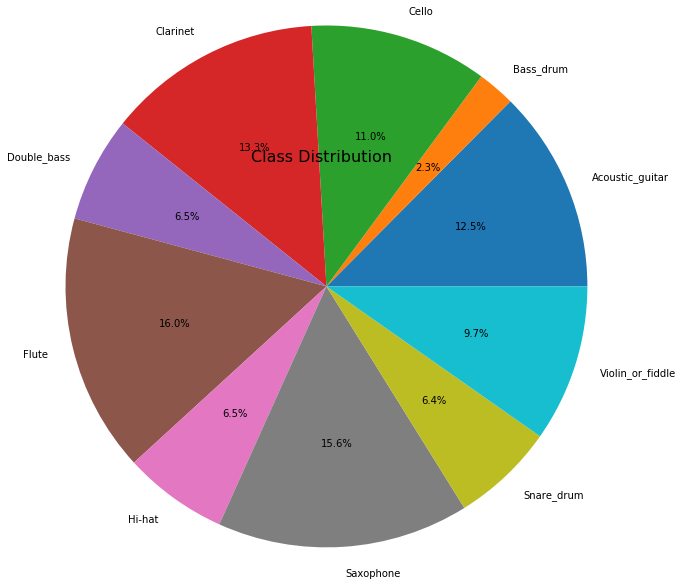

In [6]:

df=pd.read_csv('C:\Audio-Classification-master\instruments.csv')
df.set_index('fname',inplace=True)
for f in df.index:
    rate,signal=wavfile.read('C:\Audio-Classification-master\clean/'+f)
    df.at[f,'length(in sec)']=(signal.shape[0])/rate
    
classes=list(np.unique(df.label))
class_dist=df.groupby([df.label])['length(in sec)'].mean()
print(class_dist)
fig,ax=plt.subplots()
fig.suptitle('Class Distribution',size=16)
ax.pie(class_dist,labels=classes,autopct='%1.1f%%',radius=3.0)
plt.show()
with open('C:\Audio-Classification-master\pickles\class_dist.p','wb') as handle:
    pickle.dump((class_dist,classes),handle,protocol=pickle.HIGHEST_PROTOCOL)


<h2>Creating Data Randomly</h2>

In [7]:
def check_data():
    if os.path.isfile(config.p_path):
        print("Loading the data from {} model".format(config.mode))
        with open(config.p_path,'rb') as handle:
            tmp=pickle.load(handle)
            return tmp
    else:
        return None

In [8]:
with open('C:\Audio-Classification-master\pickles\class_dist.p','rb') as handle:
        class_dist,classes=pickle.load(handle)

In [9]:
class_dist

label
Acoustic_guitar     5.523710
Bass_drum           1.028431
Cello               4.857862
Clarinet            5.872040
Double_bass         2.877908
Flute               7.040535
Hi-hat              2.847860
Saxophone           6.864981
Snare_drum          2.817537
Violin_or_fiddle    4.286144
Name: length(in sec), dtype: float64

<h3>Creating sample data so that we get more training data to train our model(initially,30 audio files were very less to train our model and get a good accuracy with that)</h3>

In [27]:
def inputOutput():
    if(check_data()):
        tem=check_data()
        return tem[0],tem[1]
    else:
        X=[]
        y=[]
        _min,_max=float('inf'),-float('inf')
        for _ in tqdm(range(n_samples)):
            rand_class=np.random.choice(class_dist.index,p=prob_dist)
            file=np.random.choice(df[df.label==rand_class].index)
            rate,sig=wavfile.read('C:\Audio-Classification-master\clean/'+file)
            rand_index=np.random.randint(0,sig.shape[0]-config.step)
            sample=sig[rand_index:rand_index+config.step]
            X_sample=mfcc(sample,rate,numcep=config.ncep,nfilt=config.nfilt,nfft=config.nfft)#No. of frames here would be ((1/10)*1000ms)/(winstep=10ms)=100ms/10ms=10
            _min=min(np.amin(X_sample),_min)
            config.min=_min
            _max=max(np.amax(X_sample),_max)
            config.max=_max
            X.append(X_sample)
            y.append(classes.index(rand_class))
        X,y=np.array(X),np.array(y)
        X=(X-_min)/(_max-_min)
        if config.mode=='CNN' or config.mode=='RCNN':
            X=X.reshape(X.shape[0],X.shape[2],X.shape[1],1)
        else:
            X=X.reshape(X.shape[0],X.shape[2],X.shape[1])
        y=to_categorical(y,num_classes=len(classes))

        with open(config.p_path,'wb') as handle:
            pickle.dump((X,y,_min,_max),handle,protocol=pickle.HIGHEST_PROTOCOL)

        return X,y    

In [28]:
n_samples=60000
prob_dist=class_dist/class_dist.sum()
#choice=np.random.choice(class_dist.index,p=prob_dist)
print(n_samples)
print('Enter the type of model:')
print('CNN for Convolutional Neural Network(CNN)')
print('RNN for Recurrent Neural Network(RNN)')
print('RCNN for Recurrent Convolutional Neural Network(RCNN)')
config=Config(mode=input())
if config.mode=="CNN":
    X,y=inputOutput()
    y_flat=np.argmax(y,axis=1)
    input_shape=(X.shape[1],X.shape[2],1)
    model=get_conv_model()
    model.summary()
    
elif config.mode=="RNN":
    X,y=inputOutput()
    X=X.reshape(X.shape[0],X.shape[2],X.shape[1])
    y_flat=np.argmax(y,axis=1)
    input_shape=(X.shape[2],X.shape[1])
    model=get_recurrent_model()
else:
    X,y=inputOutput()
    y_flat=np.argmax(y,axis=1)
    input_shape=(X.shape[1],X.shape[2],1)
    model=get_CRNN_model()
    model.summary()
    
class_weights=compute_class_weight('balanced',np.unique(y_flat),y_flat)
#checkpoint=ModelCheckpoint("C:\Audio-Classification-master\models\RCNN",monitor='val_acc',mode='max',verbose=1,save_best_only=True,save_weights_only=False,period=1)

model.fit(X,y,epochs=10,shuffle=True,validation_split=0.05,batch_size=32,class_weight=class_weights,use_multiprocessing=False)#validation_split
model.save(config.model_path)


60000
Enter the type of model:
CNN for Convolutional Neural Network(CNN)
RNN for Recurrent Neural Network(RNN)
RCNN for Recurrent Convolutional Neural Network(RCNN)
CNN
Loading the data from CNN model
Loading the data from CNN model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 9, 16)         160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 9, 32)         4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 4, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 4, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 4, 128)         73856     
_____________________

 6528/57000 [==>...........................] - ETA: 24:23 - loss: 2.2995 - acc: 0.15 - ETA: 13:42 - loss: 2.2916 - acc: 0.17 - ETA: 10:10 - loss: 2.3134 - acc: 0.13 - ETA: 8:10 - loss: 2.3024 - acc: 0.1328 - ETA: 6:56 - loss: 2.2936 - acc: 0.131 - ETA: 6:06 - loss: 2.2842 - acc: 0.140 - ETA: 5:29 - loss: 2.2697 - acc: 0.142 - ETA: 5:03 - loss: 2.2655 - acc: 0.140 - ETA: 4:43 - loss: 2.2729 - acc: 0.131 - ETA: 4:31 - loss: 2.2743 - acc: 0.134 - ETA: 4:23 - loss: 2.2681 - acc: 0.125 - ETA: 4:14 - loss: 2.2675 - acc: 0.127 - ETA: 4:03 - loss: 2.2682 - acc: 0.125 - ETA: 3:56 - loss: 2.2651 - acc: 0.122 - ETA: 3:48 - loss: 2.2649 - acc: 0.122 - ETA: 3:42 - loss: 2.2616 - acc: 0.125 - ETA: 3:35 - loss: 2.2577 - acc: 0.130 - ETA: 3:32 - loss: 2.2544 - acc: 0.126 - ETA: 3:29 - loss: 2.2524 - acc: 0.128 - ETA: 3:24 - loss: 2.2493 - acc: 0.132 - ETA: 3:21 - loss: 2.2446 - acc: 0.136 - ETA: 3:17 - loss: 2.2354 - acc: 0.137 - ETA: 3:14 - loss: 2.2382 - acc: 0.137 - ETA: 3:11 - loss: 2.2478 - acc: 

13056/57000 [=====>........................] - ETA: 1:47 - loss: 2.0726 - acc: 0.198 - ETA: 1:46 - loss: 2.0719 - acc: 0.199 - ETA: 1:46 - loss: 2.0708 - acc: 0.199 - ETA: 1:46 - loss: 2.0692 - acc: 0.200 - ETA: 1:46 - loss: 2.0680 - acc: 0.201 - ETA: 1:46 - loss: 2.0661 - acc: 0.201 - ETA: 1:46 - loss: 2.0644 - acc: 0.202 - ETA: 1:46 - loss: 2.0622 - acc: 0.203 - ETA: 1:45 - loss: 2.0598 - acc: 0.204 - ETA: 1:45 - loss: 2.0580 - acc: 0.205 - ETA: 1:45 - loss: 2.0560 - acc: 0.206 - ETA: 1:45 - loss: 2.0554 - acc: 0.207 - ETA: 1:45 - loss: 2.0530 - acc: 0.208 - ETA: 1:45 - loss: 2.0508 - acc: 0.209 - ETA: 1:45 - loss: 2.0489 - acc: 0.211 - ETA: 1:44 - loss: 2.0464 - acc: 0.212 - ETA: 1:44 - loss: 2.0432 - acc: 0.213 - ETA: 1:44 - loss: 2.0396 - acc: 0.215 - ETA: 1:44 - loss: 2.0375 - acc: 0.216 - ETA: 1:44 - loss: 2.0363 - acc: 0.217 - ETA: 1:44 - loss: 2.0343 - acc: 0.218 - ETA: 1:44 - loss: 2.0315 - acc: 0.219 - ETA: 1:44 - loss: 2.0304 - acc: 0.220 - ETA: 1:43 - loss: 2.0289 - acc: 0

19584/57000 [=========>....................] - ETA: 1:26 - loss: 1.7331 - acc: 0.341 - ETA: 1:26 - loss: 1.7318 - acc: 0.341 - ETA: 1:26 - loss: 1.7305 - acc: 0.342 - ETA: 1:26 - loss: 1.7299 - acc: 0.342 - ETA: 1:26 - loss: 1.7287 - acc: 0.342 - ETA: 1:26 - loss: 1.7278 - acc: 0.343 - ETA: 1:26 - loss: 1.7264 - acc: 0.343 - ETA: 1:26 - loss: 1.7249 - acc: 0.344 - ETA: 1:26 - loss: 1.7240 - acc: 0.344 - ETA: 1:25 - loss: 1.7230 - acc: 0.344 - ETA: 1:25 - loss: 1.7215 - acc: 0.345 - ETA: 1:25 - loss: 1.7207 - acc: 0.345 - ETA: 1:25 - loss: 1.7198 - acc: 0.346 - ETA: 1:25 - loss: 1.7184 - acc: 0.346 - ETA: 1:25 - loss: 1.7178 - acc: 0.347 - ETA: 1:25 - loss: 1.7164 - acc: 0.347 - ETA: 1:25 - loss: 1.7154 - acc: 0.348 - ETA: 1:25 - loss: 1.7139 - acc: 0.349 - ETA: 1:25 - loss: 1.7126 - acc: 0.349 - ETA: 1:25 - loss: 1.7114 - acc: 0.350 - ETA: 1:25 - loss: 1.7118 - acc: 0.350 - ETA: 1:24 - loss: 1.7109 - acc: 0.350 - ETA: 1:24 - loss: 1.7091 - acc: 0.351 - ETA: 1:24 - loss: 1.7075 - acc: 0

26144/57000 [============>.................] - ETA: 1:12 - loss: 1.5098 - acc: 0.434 - ETA: 1:12 - loss: 1.5089 - acc: 0.434 - ETA: 1:11 - loss: 1.5078 - acc: 0.435 - ETA: 1:11 - loss: 1.5063 - acc: 0.435 - ETA: 1:11 - loss: 1.5055 - acc: 0.436 - ETA: 1:11 - loss: 1.5046 - acc: 0.436 - ETA: 1:11 - loss: 1.5031 - acc: 0.437 - ETA: 1:11 - loss: 1.5023 - acc: 0.437 - ETA: 1:11 - loss: 1.5020 - acc: 0.437 - ETA: 1:11 - loss: 1.5012 - acc: 0.438 - ETA: 1:11 - loss: 1.5002 - acc: 0.438 - ETA: 1:11 - loss: 1.4988 - acc: 0.439 - ETA: 1:11 - loss: 1.4983 - acc: 0.439 - ETA: 1:11 - loss: 1.4975 - acc: 0.439 - ETA: 1:11 - loss: 1.4965 - acc: 0.440 - ETA: 1:11 - loss: 1.4957 - acc: 0.440 - ETA: 1:11 - loss: 1.4952 - acc: 0.440 - ETA: 1:10 - loss: 1.4942 - acc: 0.440 - ETA: 1:10 - loss: 1.4933 - acc: 0.441 - ETA: 1:10 - loss: 1.4925 - acc: 0.441 - ETA: 1:10 - loss: 1.4911 - acc: 0.442 - ETA: 1:10 - loss: 1.4899 - acc: 0.442 - ETA: 1:10 - loss: 1.4888 - acc: 0.442 - ETA: 1:10 - loss: 1.4883 - acc: 0

33024/57000 [================>.............] - ETA: 58s - loss: 1.3493 - acc: 0.50 - ETA: 58s - loss: 1.3487 - acc: 0.50 - ETA: 58s - loss: 1.3479 - acc: 0.50 - ETA: 58s - loss: 1.3468 - acc: 0.50 - ETA: 58s - loss: 1.3465 - acc: 0.50 - ETA: 58s - loss: 1.3462 - acc: 0.50 - ETA: 58s - loss: 1.3457 - acc: 0.50 - ETA: 58s - loss: 1.3449 - acc: 0.50 - ETA: 58s - loss: 1.3441 - acc: 0.50 - ETA: 58s - loss: 1.3432 - acc: 0.50 - ETA: 58s - loss: 1.3426 - acc: 0.50 - ETA: 58s - loss: 1.3421 - acc: 0.50 - ETA: 58s - loss: 1.3415 - acc: 0.50 - ETA: 58s - loss: 1.3407 - acc: 0.50 - ETA: 58s - loss: 1.3399 - acc: 0.50 - ETA: 57s - loss: 1.3396 - acc: 0.50 - ETA: 57s - loss: 1.3395 - acc: 0.50 - ETA: 57s - loss: 1.3388 - acc: 0.50 - ETA: 57s - loss: 1.3383 - acc: 0.50 - ETA: 57s - loss: 1.3375 - acc: 0.50 - ETA: 57s - loss: 1.3371 - acc: 0.50 - ETA: 57s - loss: 1.3364 - acc: 0.50 - ETA: 57s - loss: 1.3358 - acc: 0.50 - ETA: 57s - loss: 1.3350 - acc: 0.50 - ETA: 57s - loss: 1.3342 - acc: 0.50 - ETA

39904/57000 [====================>.........] - ETA: 45s - loss: 1.2220 - acc: 0.55 - ETA: 45s - loss: 1.2214 - acc: 0.55 - ETA: 45s - loss: 1.2209 - acc: 0.55 - ETA: 45s - loss: 1.2207 - acc: 0.55 - ETA: 45s - loss: 1.2202 - acc: 0.55 - ETA: 45s - loss: 1.2195 - acc: 0.55 - ETA: 45s - loss: 1.2190 - acc: 0.55 - ETA: 44s - loss: 1.2185 - acc: 0.55 - ETA: 44s - loss: 1.2180 - acc: 0.55 - ETA: 44s - loss: 1.2175 - acc: 0.55 - ETA: 44s - loss: 1.2168 - acc: 0.55 - ETA: 44s - loss: 1.2164 - acc: 0.55 - ETA: 44s - loss: 1.2156 - acc: 0.55 - ETA: 44s - loss: 1.2151 - acc: 0.55 - ETA: 44s - loss: 1.2147 - acc: 0.55 - ETA: 44s - loss: 1.2139 - acc: 0.55 - ETA: 44s - loss: 1.2132 - acc: 0.55 - ETA: 44s - loss: 1.2126 - acc: 0.55 - ETA: 44s - loss: 1.2119 - acc: 0.55 - ETA: 44s - loss: 1.2114 - acc: 0.55 - ETA: 44s - loss: 1.2107 - acc: 0.55 - ETA: 44s - loss: 1.2102 - acc: 0.55 - ETA: 44s - loss: 1.2096 - acc: 0.55 - ETA: 43s - loss: 1.2090 - acc: 0.55 - ETA: 43s - loss: 1.2084 - acc: 0.55 - ETA

46784/57000 [=======================>......] - ETA: 32s - loss: 1.1176 - acc: 0.59 - ETA: 32s - loss: 1.1171 - acc: 0.59 - ETA: 32s - loss: 1.1165 - acc: 0.59 - ETA: 31s - loss: 1.1159 - acc: 0.59 - ETA: 31s - loss: 1.1156 - acc: 0.59 - ETA: 31s - loss: 1.1150 - acc: 0.59 - ETA: 31s - loss: 1.1143 - acc: 0.59 - ETA: 31s - loss: 1.1139 - acc: 0.59 - ETA: 31s - loss: 1.1136 - acc: 0.59 - ETA: 31s - loss: 1.1134 - acc: 0.59 - ETA: 31s - loss: 1.1129 - acc: 0.59 - ETA: 31s - loss: 1.1126 - acc: 0.59 - ETA: 31s - loss: 1.1122 - acc: 0.59 - ETA: 31s - loss: 1.1117 - acc: 0.59 - ETA: 31s - loss: 1.1112 - acc: 0.59 - ETA: 31s - loss: 1.1106 - acc: 0.59 - ETA: 31s - loss: 1.1103 - acc: 0.59 - ETA: 31s - loss: 1.1098 - acc: 0.59 - ETA: 31s - loss: 1.1094 - acc: 0.59 - ETA: 30s - loss: 1.1088 - acc: 0.59 - ETA: 30s - loss: 1.1084 - acc: 0.59 - ETA: 30s - loss: 1.1080 - acc: 0.59 - ETA: 30s - loss: 1.1076 - acc: 0.59 - ETA: 30s - loss: 1.1072 - acc: 0.59 - ETA: 30s - loss: 1.1066 - acc: 0.59 - ETA

53664/57000 [===========================>..] - ETA: 19s - loss: 1.0364 - acc: 0.62 - ETA: 19s - loss: 1.0360 - acc: 0.62 - ETA: 18s - loss: 1.0357 - acc: 0.62 - ETA: 18s - loss: 1.0354 - acc: 0.62 - ETA: 18s - loss: 1.0349 - acc: 0.62 - ETA: 18s - loss: 1.0344 - acc: 0.62 - ETA: 18s - loss: 1.0342 - acc: 0.62 - ETA: 18s - loss: 1.0337 - acc: 0.62 - ETA: 18s - loss: 1.0334 - acc: 0.62 - ETA: 18s - loss: 1.0331 - acc: 0.62 - ETA: 18s - loss: 1.0328 - acc: 0.62 - ETA: 18s - loss: 1.0325 - acc: 0.62 - ETA: 18s - loss: 1.0322 - acc: 0.62 - ETA: 18s - loss: 1.0316 - acc: 0.62 - ETA: 18s - loss: 1.0312 - acc: 0.62 - ETA: 18s - loss: 1.0308 - acc: 0.62 - ETA: 18s - loss: 1.0304 - acc: 0.62 - ETA: 18s - loss: 1.0301 - acc: 0.62 - ETA: 18s - loss: 1.0299 - acc: 0.62 - ETA: 17s - loss: 1.0297 - acc: 0.62 - ETA: 17s - loss: 1.0293 - acc: 0.62 - ETA: 17s - loss: 1.0291 - acc: 0.62 - ETA: 17s - loss: 1.0287 - acc: 0.62 - ETA: 17s - loss: 1.0284 - acc: 0.62 - ETA: 17s - loss: 1.0280 - acc: 0.62 - ETA

57000/57000 [==============================] - ETA: 6s - loss: 0.9654 - acc: 0.652 - ETA: 6s - loss: 0.9651 - acc: 0.652 - ETA: 6s - loss: 0.9647 - acc: 0.652 - ETA: 6s - loss: 0.9645 - acc: 0.652 - ETA: 5s - loss: 0.9642 - acc: 0.652 - ETA: 5s - loss: 0.9639 - acc: 0.652 - ETA: 5s - loss: 0.9635 - acc: 0.653 - ETA: 5s - loss: 0.9632 - acc: 0.653 - ETA: 5s - loss: 0.9629 - acc: 0.653 - ETA: 5s - loss: 0.9626 - acc: 0.653 - ETA: 5s - loss: 0.9624 - acc: 0.653 - ETA: 5s - loss: 0.9619 - acc: 0.653 - ETA: 5s - loss: 0.9618 - acc: 0.653 - ETA: 5s - loss: 0.9615 - acc: 0.653 - ETA: 5s - loss: 0.9611 - acc: 0.653 - ETA: 5s - loss: 0.9610 - acc: 0.653 - ETA: 5s - loss: 0.9606 - acc: 0.654 - ETA: 5s - loss: 0.9604 - acc: 0.654 - ETA: 5s - loss: 0.9601 - acc: 0.654 - ETA: 5s - loss: 0.9598 - acc: 0.654 - ETA: 4s - loss: 0.9595 - acc: 0.654 - ETA: 4s - loss: 0.9592 - acc: 0.654 - ETA: 4s - loss: 0.9590 - acc: 0.654 - ETA: 4s - loss: 0.9587 - acc: 0.654 - ETA: 4s - loss: 0.9586 - acc: 0.654 - ETA

 6528/57000 [==>...........................] - ETA: 1:41 - loss: 0.5084 - acc: 0.812 - ETA: 1:41 - loss: 0.4884 - acc: 0.781 - ETA: 1:41 - loss: 0.4483 - acc: 0.802 - ETA: 1:41 - loss: 0.4453 - acc: 0.804 - ETA: 1:41 - loss: 0.4210 - acc: 0.831 - ETA: 1:41 - loss: 0.4430 - acc: 0.828 - ETA: 1:42 - loss: 0.4273 - acc: 0.830 - ETA: 1:41 - loss: 0.4088 - acc: 0.839 - ETA: 1:41 - loss: 0.4029 - acc: 0.843 - ETA: 1:41 - loss: 0.3874 - acc: 0.853 - ETA: 1:41 - loss: 0.3928 - acc: 0.852 - ETA: 1:41 - loss: 0.4121 - acc: 0.846 - ETA: 1:41 - loss: 0.4023 - acc: 0.851 - ETA: 1:41 - loss: 0.4174 - acc: 0.846 - ETA: 1:41 - loss: 0.4314 - acc: 0.837 - ETA: 1:41 - loss: 0.4486 - acc: 0.834 - ETA: 1:41 - loss: 0.4462 - acc: 0.838 - ETA: 1:41 - loss: 0.4422 - acc: 0.838 - ETA: 1:40 - loss: 0.4510 - acc: 0.832 - ETA: 1:41 - loss: 0.4552 - acc: 0.829 - ETA: 1:40 - loss: 0.4533 - acc: 0.828 - ETA: 1:41 - loss: 0.4560 - acc: 0.829 - ETA: 1:41 - loss: 0.4481 - acc: 0.831 - ETA: 1:41 - loss: 0.4404 - acc: 0

13056/57000 [=====>........................] - ETA: 1:33 - loss: 0.4195 - acc: 0.850 - ETA: 1:33 - loss: 0.4192 - acc: 0.850 - ETA: 1:33 - loss: 0.4187 - acc: 0.850 - ETA: 1:33 - loss: 0.4181 - acc: 0.850 - ETA: 1:33 - loss: 0.4180 - acc: 0.850 - ETA: 1:33 - loss: 0.4176 - acc: 0.851 - ETA: 1:33 - loss: 0.4169 - acc: 0.851 - ETA: 1:32 - loss: 0.4169 - acc: 0.851 - ETA: 1:32 - loss: 0.4160 - acc: 0.852 - ETA: 1:32 - loss: 0.4148 - acc: 0.852 - ETA: 1:32 - loss: 0.4157 - acc: 0.851 - ETA: 1:32 - loss: 0.4180 - acc: 0.851 - ETA: 1:32 - loss: 0.4173 - acc: 0.851 - ETA: 1:32 - loss: 0.4179 - acc: 0.851 - ETA: 1:32 - loss: 0.4185 - acc: 0.850 - ETA: 1:32 - loss: 0.4187 - acc: 0.851 - ETA: 1:32 - loss: 0.4178 - acc: 0.851 - ETA: 1:32 - loss: 0.4172 - acc: 0.851 - ETA: 1:32 - loss: 0.4165 - acc: 0.851 - ETA: 1:32 - loss: 0.4166 - acc: 0.851 - ETA: 1:32 - loss: 0.4157 - acc: 0.851 - ETA: 1:31 - loss: 0.4170 - acc: 0.851 - ETA: 1:31 - loss: 0.4163 - acc: 0.851 - ETA: 1:31 - loss: 0.4159 - acc: 0

19584/57000 [=========>....................] - ETA: 1:21 - loss: 0.4050 - acc: 0.859 - ETA: 1:21 - loss: 0.4047 - acc: 0.859 - ETA: 1:21 - loss: 0.4052 - acc: 0.859 - ETA: 1:20 - loss: 0.4050 - acc: 0.859 - ETA: 1:20 - loss: 0.4049 - acc: 0.859 - ETA: 1:20 - loss: 0.4050 - acc: 0.859 - ETA: 1:20 - loss: 0.4047 - acc: 0.859 - ETA: 1:20 - loss: 0.4047 - acc: 0.859 - ETA: 1:20 - loss: 0.4047 - acc: 0.859 - ETA: 1:20 - loss: 0.4044 - acc: 0.859 - ETA: 1:20 - loss: 0.4046 - acc: 0.859 - ETA: 1:20 - loss: 0.4045 - acc: 0.859 - ETA: 1:20 - loss: 0.4042 - acc: 0.859 - ETA: 1:20 - loss: 0.4041 - acc: 0.859 - ETA: 1:20 - loss: 0.4049 - acc: 0.859 - ETA: 1:20 - loss: 0.4050 - acc: 0.859 - ETA: 1:20 - loss: 0.4049 - acc: 0.859 - ETA: 1:20 - loss: 0.4050 - acc: 0.859 - ETA: 1:20 - loss: 0.4052 - acc: 0.859 - ETA: 1:19 - loss: 0.4053 - acc: 0.859 - ETA: 1:19 - loss: 0.4050 - acc: 0.859 - ETA: 1:19 - loss: 0.4047 - acc: 0.859 - ETA: 1:19 - loss: 0.4041 - acc: 0.859 - ETA: 1:19 - loss: 0.4043 - acc: 0

26208/57000 [============>.................] - ETA: 1:09 - loss: 0.3922 - acc: 0.864 - ETA: 1:09 - loss: 0.3918 - acc: 0.865 - ETA: 1:09 - loss: 0.3919 - acc: 0.865 - ETA: 1:08 - loss: 0.3921 - acc: 0.865 - ETA: 1:08 - loss: 0.3920 - acc: 0.864 - ETA: 1:08 - loss: 0.3922 - acc: 0.864 - ETA: 1:08 - loss: 0.3922 - acc: 0.864 - ETA: 1:08 - loss: 0.3919 - acc: 0.864 - ETA: 1:08 - loss: 0.3921 - acc: 0.864 - ETA: 1:08 - loss: 0.3921 - acc: 0.864 - ETA: 1:08 - loss: 0.3922 - acc: 0.864 - ETA: 1:08 - loss: 0.3922 - acc: 0.864 - ETA: 1:08 - loss: 0.3921 - acc: 0.864 - ETA: 1:08 - loss: 0.3918 - acc: 0.864 - ETA: 1:08 - loss: 0.3919 - acc: 0.864 - ETA: 1:08 - loss: 0.3919 - acc: 0.864 - ETA: 1:08 - loss: 0.3922 - acc: 0.864 - ETA: 1:08 - loss: 0.3919 - acc: 0.864 - ETA: 1:08 - loss: 0.3918 - acc: 0.864 - ETA: 1:07 - loss: 0.3915 - acc: 0.864 - ETA: 1:07 - loss: 0.3913 - acc: 0.864 - ETA: 1:07 - loss: 0.3909 - acc: 0.864 - ETA: 1:07 - loss: 0.3910 - acc: 0.864 - ETA: 1:07 - loss: 0.3908 - acc: 0

33088/57000 [================>.............] - ETA: 56s - loss: 0.3835 - acc: 0.86 - ETA: 56s - loss: 0.3837 - acc: 0.86 - ETA: 56s - loss: 0.3836 - acc: 0.86 - ETA: 56s - loss: 0.3833 - acc: 0.86 - ETA: 56s - loss: 0.3834 - acc: 0.86 - ETA: 56s - loss: 0.3833 - acc: 0.86 - ETA: 56s - loss: 0.3833 - acc: 0.86 - ETA: 56s - loss: 0.3833 - acc: 0.86 - ETA: 56s - loss: 0.3831 - acc: 0.86 - ETA: 56s - loss: 0.3830 - acc: 0.86 - ETA: 56s - loss: 0.3828 - acc: 0.86 - ETA: 56s - loss: 0.3825 - acc: 0.86 - ETA: 56s - loss: 0.3828 - acc: 0.86 - ETA: 56s - loss: 0.3825 - acc: 0.86 - ETA: 56s - loss: 0.3822 - acc: 0.86 - ETA: 56s - loss: 0.3823 - acc: 0.86 - ETA: 56s - loss: 0.3821 - acc: 0.86 - ETA: 56s - loss: 0.3819 - acc: 0.86 - ETA: 55s - loss: 0.3816 - acc: 0.86 - ETA: 55s - loss: 0.3814 - acc: 0.86 - ETA: 55s - loss: 0.3812 - acc: 0.86 - ETA: 55s - loss: 0.3815 - acc: 0.86 - ETA: 55s - loss: 0.3815 - acc: 0.86 - ETA: 55s - loss: 0.3813 - acc: 0.86 - ETA: 55s - loss: 0.3811 - acc: 0.86 - ETA

39968/57000 [====================>.........] - ETA: 44s - loss: 0.3716 - acc: 0.87 - ETA: 44s - loss: 0.3717 - acc: 0.87 - ETA: 44s - loss: 0.3715 - acc: 0.87 - ETA: 44s - loss: 0.3714 - acc: 0.87 - ETA: 44s - loss: 0.3716 - acc: 0.87 - ETA: 43s - loss: 0.3715 - acc: 0.87 - ETA: 43s - loss: 0.3712 - acc: 0.87 - ETA: 43s - loss: 0.3711 - acc: 0.87 - ETA: 43s - loss: 0.3711 - acc: 0.87 - ETA: 43s - loss: 0.3708 - acc: 0.87 - ETA: 43s - loss: 0.3706 - acc: 0.87 - ETA: 43s - loss: 0.3705 - acc: 0.87 - ETA: 43s - loss: 0.3704 - acc: 0.87 - ETA: 43s - loss: 0.3701 - acc: 0.87 - ETA: 43s - loss: 0.3701 - acc: 0.87 - ETA: 43s - loss: 0.3702 - acc: 0.87 - ETA: 43s - loss: 0.3702 - acc: 0.87 - ETA: 43s - loss: 0.3701 - acc: 0.87 - ETA: 43s - loss: 0.3701 - acc: 0.87 - ETA: 43s - loss: 0.3700 - acc: 0.87 - ETA: 43s - loss: 0.3699 - acc: 0.87 - ETA: 43s - loss: 0.3698 - acc: 0.87 - ETA: 42s - loss: 0.3697 - acc: 0.87 - ETA: 42s - loss: 0.3695 - acc: 0.87 - ETA: 42s - loss: 0.3694 - acc: 0.87 - ETA

46848/57000 [=======================>......] - ETA: 31s - loss: 0.3630 - acc: 0.87 - ETA: 31s - loss: 0.3630 - acc: 0.87 - ETA: 31s - loss: 0.3630 - acc: 0.87 - ETA: 31s - loss: 0.3628 - acc: 0.87 - ETA: 31s - loss: 0.3629 - acc: 0.87 - ETA: 31s - loss: 0.3628 - acc: 0.87 - ETA: 31s - loss: 0.3627 - acc: 0.87 - ETA: 31s - loss: 0.3625 - acc: 0.87 - ETA: 31s - loss: 0.3625 - acc: 0.87 - ETA: 30s - loss: 0.3623 - acc: 0.87 - ETA: 30s - loss: 0.3622 - acc: 0.87 - ETA: 30s - loss: 0.3621 - acc: 0.87 - ETA: 30s - loss: 0.3621 - acc: 0.87 - ETA: 30s - loss: 0.3622 - acc: 0.87 - ETA: 30s - loss: 0.3622 - acc: 0.87 - ETA: 30s - loss: 0.3622 - acc: 0.87 - ETA: 30s - loss: 0.3621 - acc: 0.87 - ETA: 30s - loss: 0.3620 - acc: 0.87 - ETA: 30s - loss: 0.3621 - acc: 0.87 - ETA: 30s - loss: 0.3621 - acc: 0.87 - ETA: 30s - loss: 0.3624 - acc: 0.87 - ETA: 30s - loss: 0.3623 - acc: 0.87 - ETA: 30s - loss: 0.3622 - acc: 0.87 - ETA: 30s - loss: 0.3621 - acc: 0.87 - ETA: 30s - loss: 0.3621 - acc: 0.87 - ETA

53728/57000 [===========================>..] - ETA: 18s - loss: 0.3544 - acc: 0.87 - ETA: 18s - loss: 0.3542 - acc: 0.87 - ETA: 18s - loss: 0.3541 - acc: 0.87 - ETA: 18s - loss: 0.3541 - acc: 0.87 - ETA: 18s - loss: 0.3541 - acc: 0.87 - ETA: 18s - loss: 0.3540 - acc: 0.87 - ETA: 18s - loss: 0.3539 - acc: 0.87 - ETA: 18s - loss: 0.3539 - acc: 0.87 - ETA: 18s - loss: 0.3538 - acc: 0.87 - ETA: 18s - loss: 0.3538 - acc: 0.87 - ETA: 18s - loss: 0.3537 - acc: 0.87 - ETA: 18s - loss: 0.3536 - acc: 0.87 - ETA: 18s - loss: 0.3537 - acc: 0.87 - ETA: 17s - loss: 0.3536 - acc: 0.87 - ETA: 17s - loss: 0.3536 - acc: 0.87 - ETA: 17s - loss: 0.3535 - acc: 0.87 - ETA: 17s - loss: 0.3533 - acc: 0.87 - ETA: 17s - loss: 0.3532 - acc: 0.87 - ETA: 17s - loss: 0.3531 - acc: 0.87 - ETA: 17s - loss: 0.3530 - acc: 0.87 - ETA: 17s - loss: 0.3530 - acc: 0.87 - ETA: 17s - loss: 0.3528 - acc: 0.87 - ETA: 17s - loss: 0.3527 - acc: 0.87 - ETA: 17s - loss: 0.3526 - acc: 0.87 - ETA: 17s - loss: 0.3525 - acc: 0.87 - ETA

57000/57000 [==============================] - ETA: 5s - loss: 0.3448 - acc: 0.881 - ETA: 5s - loss: 0.3447 - acc: 0.881 - ETA: 5s - loss: 0.3447 - acc: 0.881 - ETA: 5s - loss: 0.3446 - acc: 0.881 - ETA: 5s - loss: 0.3445 - acc: 0.881 - ETA: 5s - loss: 0.3444 - acc: 0.881 - ETA: 5s - loss: 0.3445 - acc: 0.881 - ETA: 5s - loss: 0.3443 - acc: 0.881 - ETA: 5s - loss: 0.3443 - acc: 0.881 - ETA: 5s - loss: 0.3445 - acc: 0.881 - ETA: 5s - loss: 0.3445 - acc: 0.881 - ETA: 5s - loss: 0.3444 - acc: 0.881 - ETA: 5s - loss: 0.3444 - acc: 0.881 - ETA: 5s - loss: 0.3443 - acc: 0.881 - ETA: 5s - loss: 0.3444 - acc: 0.881 - ETA: 5s - loss: 0.3443 - acc: 0.881 - ETA: 5s - loss: 0.3443 - acc: 0.881 - ETA: 4s - loss: 0.3443 - acc: 0.881 - ETA: 4s - loss: 0.3442 - acc: 0.881 - ETA: 4s - loss: 0.3442 - acc: 0.881 - ETA: 4s - loss: 0.3441 - acc: 0.881 - ETA: 4s - loss: 0.3439 - acc: 0.881 - ETA: 4s - loss: 0.3439 - acc: 0.881 - ETA: 4s - loss: 0.3439 - acc: 0.881 - ETA: 4s - loss: 0.3438 - acc: 0.881 - ETA

 6528/57000 [==>...........................] - ETA: 1:44 - loss: 0.2622 - acc: 0.875 - ETA: 1:49 - loss: 0.2315 - acc: 0.906 - ETA: 1:47 - loss: 0.2280 - acc: 0.916 - ETA: 1:47 - loss: 0.2066 - acc: 0.921 - ETA: 1:46 - loss: 0.2361 - acc: 0.906 - ETA: 1:46 - loss: 0.2108 - acc: 0.921 - ETA: 1:46 - loss: 0.2095 - acc: 0.924 - ETA: 1:46 - loss: 0.2360 - acc: 0.910 - ETA: 1:45 - loss: 0.2425 - acc: 0.909 - ETA: 1:45 - loss: 0.2286 - acc: 0.915 - ETA: 1:45 - loss: 0.2334 - acc: 0.917 - ETA: 1:45 - loss: 0.2565 - acc: 0.908 - ETA: 1:44 - loss: 0.2682 - acc: 0.903 - ETA: 1:44 - loss: 0.2959 - acc: 0.899 - ETA: 1:44 - loss: 0.2908 - acc: 0.900 - ETA: 1:44 - loss: 0.2870 - acc: 0.902 - ETA: 1:44 - loss: 0.2824 - acc: 0.904 - ETA: 1:44 - loss: 0.2838 - acc: 0.901 - ETA: 1:44 - loss: 0.2763 - acc: 0.903 - ETA: 1:44 - loss: 0.2864 - acc: 0.898 - ETA: 1:44 - loss: 0.2780 - acc: 0.900 - ETA: 1:44 - loss: 0.2737 - acc: 0.902 - ETA: 1:44 - loss: 0.2677 - acc: 0.903 - ETA: 1:45 - loss: 0.2630 - acc: 0

13056/57000 [=====>........................] - ETA: 1:35 - loss: 0.2423 - acc: 0.916 - ETA: 1:35 - loss: 0.2421 - acc: 0.916 - ETA: 1:35 - loss: 0.2425 - acc: 0.916 - ETA: 1:35 - loss: 0.2431 - acc: 0.916 - ETA: 1:35 - loss: 0.2427 - acc: 0.916 - ETA: 1:35 - loss: 0.2429 - acc: 0.916 - ETA: 1:35 - loss: 0.2434 - acc: 0.916 - ETA: 1:35 - loss: 0.2445 - acc: 0.916 - ETA: 1:35 - loss: 0.2443 - acc: 0.916 - ETA: 1:35 - loss: 0.2451 - acc: 0.916 - ETA: 1:34 - loss: 0.2450 - acc: 0.916 - ETA: 1:34 - loss: 0.2444 - acc: 0.917 - ETA: 1:34 - loss: 0.2443 - acc: 0.916 - ETA: 1:34 - loss: 0.2441 - acc: 0.917 - ETA: 1:34 - loss: 0.2445 - acc: 0.916 - ETA: 1:34 - loss: 0.2445 - acc: 0.916 - ETA: 1:34 - loss: 0.2438 - acc: 0.916 - ETA: 1:34 - loss: 0.2443 - acc: 0.916 - ETA: 1:34 - loss: 0.2447 - acc: 0.916 - ETA: 1:34 - loss: 0.2447 - acc: 0.916 - ETA: 1:34 - loss: 0.2447 - acc: 0.916 - ETA: 1:34 - loss: 0.2449 - acc: 0.916 - ETA: 1:34 - loss: 0.2452 - acc: 0.916 - ETA: 1:33 - loss: 0.2452 - acc: 0

19584/57000 [=========>....................] - ETA: 1:22 - loss: 0.2474 - acc: 0.916 - ETA: 1:22 - loss: 0.2483 - acc: 0.915 - ETA: 1:22 - loss: 0.2482 - acc: 0.915 - ETA: 1:22 - loss: 0.2488 - acc: 0.915 - ETA: 1:21 - loss: 0.2488 - acc: 0.915 - ETA: 1:21 - loss: 0.2486 - acc: 0.915 - ETA: 1:21 - loss: 0.2485 - acc: 0.915 - ETA: 1:21 - loss: 0.2486 - acc: 0.915 - ETA: 1:21 - loss: 0.2483 - acc: 0.915 - ETA: 1:21 - loss: 0.2484 - acc: 0.915 - ETA: 1:21 - loss: 0.2482 - acc: 0.915 - ETA: 1:21 - loss: 0.2480 - acc: 0.915 - ETA: 1:21 - loss: 0.2482 - acc: 0.915 - ETA: 1:21 - loss: 0.2482 - acc: 0.915 - ETA: 1:21 - loss: 0.2477 - acc: 0.915 - ETA: 1:21 - loss: 0.2475 - acc: 0.915 - ETA: 1:21 - loss: 0.2473 - acc: 0.915 - ETA: 1:21 - loss: 0.2474 - acc: 0.915 - ETA: 1:21 - loss: 0.2473 - acc: 0.915 - ETA: 1:21 - loss: 0.2474 - acc: 0.915 - ETA: 1:20 - loss: 0.2476 - acc: 0.915 - ETA: 1:20 - loss: 0.2480 - acc: 0.915 - ETA: 1:20 - loss: 0.2483 - acc: 0.915 - ETA: 1:20 - loss: 0.2488 - acc: 0

26176/57000 [============>.................] - ETA: 1:09 - loss: 0.2418 - acc: 0.917 - ETA: 1:09 - loss: 0.2419 - acc: 0.917 - ETA: 1:09 - loss: 0.2417 - acc: 0.917 - ETA: 1:09 - loss: 0.2418 - acc: 0.917 - ETA: 1:09 - loss: 0.2419 - acc: 0.917 - ETA: 1:09 - loss: 0.2423 - acc: 0.917 - ETA: 1:09 - loss: 0.2423 - acc: 0.917 - ETA: 1:09 - loss: 0.2422 - acc: 0.917 - ETA: 1:09 - loss: 0.2422 - acc: 0.917 - ETA: 1:09 - loss: 0.2421 - acc: 0.917 - ETA: 1:09 - loss: 0.2420 - acc: 0.917 - ETA: 1:09 - loss: 0.2419 - acc: 0.917 - ETA: 1:09 - loss: 0.2416 - acc: 0.917 - ETA: 1:08 - loss: 0.2417 - acc: 0.917 - ETA: 1:08 - loss: 0.2415 - acc: 0.917 - ETA: 1:08 - loss: 0.2413 - acc: 0.917 - ETA: 1:08 - loss: 0.2414 - acc: 0.917 - ETA: 1:08 - loss: 0.2418 - acc: 0.917 - ETA: 1:08 - loss: 0.2417 - acc: 0.917 - ETA: 1:08 - loss: 0.2415 - acc: 0.917 - ETA: 1:08 - loss: 0.2415 - acc: 0.917 - ETA: 1:08 - loss: 0.2412 - acc: 0.917 - ETA: 1:08 - loss: 0.2413 - acc: 0.917 - ETA: 1:08 - loss: 0.2413 - acc: 0

33056/57000 [================>.............] - ETA: 57s - loss: 0.2395 - acc: 0.91 - ETA: 57s - loss: 0.2394 - acc: 0.91 - ETA: 57s - loss: 0.2395 - acc: 0.91 - ETA: 57s - loss: 0.2394 - acc: 0.91 - ETA: 57s - loss: 0.2393 - acc: 0.91 - ETA: 57s - loss: 0.2398 - acc: 0.91 - ETA: 57s - loss: 0.2398 - acc: 0.91 - ETA: 57s - loss: 0.2399 - acc: 0.91 - ETA: 57s - loss: 0.2397 - acc: 0.91 - ETA: 57s - loss: 0.2399 - acc: 0.91 - ETA: 57s - loss: 0.2398 - acc: 0.91 - ETA: 57s - loss: 0.2396 - acc: 0.91 - ETA: 57s - loss: 0.2400 - acc: 0.91 - ETA: 57s - loss: 0.2401 - acc: 0.91 - ETA: 56s - loss: 0.2399 - acc: 0.91 - ETA: 56s - loss: 0.2397 - acc: 0.91 - ETA: 56s - loss: 0.2399 - acc: 0.91 - ETA: 56s - loss: 0.2399 - acc: 0.91 - ETA: 56s - loss: 0.2400 - acc: 0.91 - ETA: 56s - loss: 0.2398 - acc: 0.91 - ETA: 56s - loss: 0.2400 - acc: 0.91 - ETA: 56s - loss: 0.2401 - acc: 0.91 - ETA: 56s - loss: 0.2401 - acc: 0.91 - ETA: 56s - loss: 0.2401 - acc: 0.91 - ETA: 56s - loss: 0.2399 - acc: 0.91 - ETA

39936/57000 [====================>.........] - ETA: 46s - loss: 0.2355 - acc: 0.91 - ETA: 46s - loss: 0.2354 - acc: 0.91 - ETA: 46s - loss: 0.2354 - acc: 0.91 - ETA: 46s - loss: 0.2354 - acc: 0.91 - ETA: 46s - loss: 0.2353 - acc: 0.91 - ETA: 46s - loss: 0.2353 - acc: 0.91 - ETA: 45s - loss: 0.2352 - acc: 0.91 - ETA: 45s - loss: 0.2351 - acc: 0.91 - ETA: 45s - loss: 0.2353 - acc: 0.91 - ETA: 45s - loss: 0.2354 - acc: 0.91 - ETA: 45s - loss: 0.2353 - acc: 0.91 - ETA: 45s - loss: 0.2352 - acc: 0.91 - ETA: 45s - loss: 0.2351 - acc: 0.91 - ETA: 45s - loss: 0.2350 - acc: 0.91 - ETA: 45s - loss: 0.2350 - acc: 0.91 - ETA: 45s - loss: 0.2350 - acc: 0.91 - ETA: 45s - loss: 0.2349 - acc: 0.91 - ETA: 45s - loss: 0.2347 - acc: 0.91 - ETA: 45s - loss: 0.2347 - acc: 0.91 - ETA: 45s - loss: 0.2346 - acc: 0.91 - ETA: 45s - loss: 0.2345 - acc: 0.91 - ETA: 45s - loss: 0.2344 - acc: 0.91 - ETA: 45s - loss: 0.2344 - acc: 0.91 - ETA: 44s - loss: 0.2344 - acc: 0.91 - ETA: 44s - loss: 0.2344 - acc: 0.91 - ETA

46816/57000 [=======================>......] - ETA: 33s - loss: 0.2312 - acc: 0.92 - ETA: 33s - loss: 0.2313 - acc: 0.92 - ETA: 33s - loss: 0.2313 - acc: 0.92 - ETA: 33s - loss: 0.2312 - acc: 0.92 - ETA: 33s - loss: 0.2312 - acc: 0.92 - ETA: 33s - loss: 0.2312 - acc: 0.92 - ETA: 33s - loss: 0.2311 - acc: 0.92 - ETA: 33s - loss: 0.2310 - acc: 0.92 - ETA: 33s - loss: 0.2310 - acc: 0.92 - ETA: 33s - loss: 0.2310 - acc: 0.92 - ETA: 33s - loss: 0.2308 - acc: 0.92 - ETA: 33s - loss: 0.2307 - acc: 0.92 - ETA: 33s - loss: 0.2307 - acc: 0.92 - ETA: 33s - loss: 0.2305 - acc: 0.92 - ETA: 32s - loss: 0.2305 - acc: 0.92 - ETA: 32s - loss: 0.2305 - acc: 0.92 - ETA: 32s - loss: 0.2304 - acc: 0.92 - ETA: 32s - loss: 0.2303 - acc: 0.92 - ETA: 32s - loss: 0.2303 - acc: 0.92 - ETA: 32s - loss: 0.2305 - acc: 0.92 - ETA: 32s - loss: 0.2303 - acc: 0.92 - ETA: 32s - loss: 0.2303 - acc: 0.92 - ETA: 32s - loss: 0.2302 - acc: 0.92 - ETA: 32s - loss: 0.2302 - acc: 0.92 - ETA: 32s - loss: 0.2302 - acc: 0.92 - ETA

53696/57000 [===========================>..] - ETA: 20s - loss: 0.2272 - acc: 0.92 - ETA: 20s - loss: 0.2272 - acc: 0.92 - ETA: 20s - loss: 0.2271 - acc: 0.92 - ETA: 20s - loss: 0.2270 - acc: 0.92 - ETA: 20s - loss: 0.2269 - acc: 0.92 - ETA: 20s - loss: 0.2268 - acc: 0.92 - ETA: 20s - loss: 0.2267 - acc: 0.92 - ETA: 20s - loss: 0.2267 - acc: 0.92 - ETA: 20s - loss: 0.2267 - acc: 0.92 - ETA: 20s - loss: 0.2269 - acc: 0.92 - ETA: 19s - loss: 0.2268 - acc: 0.92 - ETA: 19s - loss: 0.2268 - acc: 0.92 - ETA: 19s - loss: 0.2267 - acc: 0.92 - ETA: 19s - loss: 0.2266 - acc: 0.92 - ETA: 19s - loss: 0.2265 - acc: 0.92 - ETA: 19s - loss: 0.2264 - acc: 0.92 - ETA: 19s - loss: 0.2263 - acc: 0.92 - ETA: 19s - loss: 0.2263 - acc: 0.92 - ETA: 19s - loss: 0.2262 - acc: 0.92 - ETA: 19s - loss: 0.2263 - acc: 0.92 - ETA: 19s - loss: 0.2263 - acc: 0.92 - ETA: 19s - loss: 0.2262 - acc: 0.92 - ETA: 19s - loss: 0.2263 - acc: 0.92 - ETA: 19s - loss: 0.2263 - acc: 0.92 - ETA: 19s - loss: 0.2262 - acc: 0.92 - ETA

57000/57000 [==============================] - ETA: 6s - loss: 0.2233 - acc: 0.923 - ETA: 6s - loss: 0.2232 - acc: 0.923 - ETA: 6s - loss: 0.2232 - acc: 0.923 - ETA: 6s - loss: 0.2232 - acc: 0.923 - ETA: 6s - loss: 0.2231 - acc: 0.923 - ETA: 6s - loss: 0.2230 - acc: 0.923 - ETA: 6s - loss: 0.2231 - acc: 0.923 - ETA: 6s - loss: 0.2231 - acc: 0.923 - ETA: 6s - loss: 0.2231 - acc: 0.923 - ETA: 6s - loss: 0.2230 - acc: 0.923 - ETA: 6s - loss: 0.2231 - acc: 0.923 - ETA: 5s - loss: 0.2230 - acc: 0.923 - ETA: 5s - loss: 0.2229 - acc: 0.923 - ETA: 5s - loss: 0.2229 - acc: 0.923 - ETA: 5s - loss: 0.2229 - acc: 0.923 - ETA: 5s - loss: 0.2229 - acc: 0.923 - ETA: 5s - loss: 0.2228 - acc: 0.923 - ETA: 5s - loss: 0.2227 - acc: 0.923 - ETA: 5s - loss: 0.2227 - acc: 0.923 - ETA: 5s - loss: 0.2227 - acc: 0.923 - ETA: 5s - loss: 0.2226 - acc: 0.923 - ETA: 5s - loss: 0.2225 - acc: 0.923 - ETA: 5s - loss: 0.2224 - acc: 0.923 - ETA: 5s - loss: 0.2223 - acc: 0.923 - ETA: 5s - loss: 0.2224 - acc: 0.923 - ETA

 6528/57000 [==>...........................] - ETA: 1:46 - loss: 0.4446 - acc: 0.937 - ETA: 1:44 - loss: 0.3472 - acc: 0.937 - ETA: 1:48 - loss: 0.2718 - acc: 0.947 - ETA: 1:48 - loss: 0.2460 - acc: 0.937 - ETA: 1:46 - loss: 0.3001 - acc: 0.906 - ETA: 1:47 - loss: 0.3171 - acc: 0.895 - ETA: 1:46 - loss: 0.2996 - acc: 0.901 - ETA: 1:47 - loss: 0.2884 - acc: 0.902 - ETA: 1:48 - loss: 0.2996 - acc: 0.899 - ETA: 1:48 - loss: 0.2898 - acc: 0.903 - ETA: 1:48 - loss: 0.2794 - acc: 0.906 - ETA: 1:47 - loss: 0.2624 - acc: 0.914 - ETA: 1:47 - loss: 0.2608 - acc: 0.913 - ETA: 1:47 - loss: 0.2455 - acc: 0.919 - ETA: 1:47 - loss: 0.2489 - acc: 0.914 - ETA: 1:47 - loss: 0.2453 - acc: 0.916 - ETA: 1:48 - loss: 0.2444 - acc: 0.919 - ETA: 1:48 - loss: 0.2501 - acc: 0.918 - ETA: 1:48 - loss: 0.2525 - acc: 0.916 - ETA: 1:48 - loss: 0.2471 - acc: 0.917 - ETA: 1:48 - loss: 0.2483 - acc: 0.918 - ETA: 1:48 - loss: 0.2423 - acc: 0.920 - ETA: 1:47 - loss: 0.2394 - acc: 0.921 - ETA: 1:47 - loss: 0.2319 - acc: 0

13056/57000 [=====>........................] - ETA: 1:36 - loss: 0.1824 - acc: 0.935 - ETA: 1:36 - loss: 0.1820 - acc: 0.935 - ETA: 1:36 - loss: 0.1819 - acc: 0.935 - ETA: 1:36 - loss: 0.1816 - acc: 0.935 - ETA: 1:36 - loss: 0.1810 - acc: 0.935 - ETA: 1:36 - loss: 0.1805 - acc: 0.936 - ETA: 1:36 - loss: 0.1812 - acc: 0.935 - ETA: 1:36 - loss: 0.1820 - acc: 0.935 - ETA: 1:36 - loss: 0.1820 - acc: 0.935 - ETA: 1:36 - loss: 0.1815 - acc: 0.935 - ETA: 1:36 - loss: 0.1813 - acc: 0.935 - ETA: 1:36 - loss: 0.1808 - acc: 0.935 - ETA: 1:36 - loss: 0.1803 - acc: 0.936 - ETA: 1:36 - loss: 0.1802 - acc: 0.936 - ETA: 1:35 - loss: 0.1801 - acc: 0.936 - ETA: 1:35 - loss: 0.1804 - acc: 0.936 - ETA: 1:35 - loss: 0.1803 - acc: 0.936 - ETA: 1:35 - loss: 0.1806 - acc: 0.936 - ETA: 1:35 - loss: 0.1804 - acc: 0.936 - ETA: 1:35 - loss: 0.1802 - acc: 0.936 - ETA: 1:35 - loss: 0.1804 - acc: 0.936 - ETA: 1:35 - loss: 0.1806 - acc: 0.936 - ETA: 1:35 - loss: 0.1810 - acc: 0.935 - ETA: 1:35 - loss: 0.1804 - acc: 0

19584/57000 [=========>....................] - ETA: 1:24 - loss: 0.1748 - acc: 0.938 - ETA: 1:24 - loss: 0.1747 - acc: 0.938 - ETA: 1:24 - loss: 0.1748 - acc: 0.938 - ETA: 1:24 - loss: 0.1746 - acc: 0.938 - ETA: 1:24 - loss: 0.1747 - acc: 0.938 - ETA: 1:24 - loss: 0.1746 - acc: 0.938 - ETA: 1:24 - loss: 0.1744 - acc: 0.938 - ETA: 1:24 - loss: 0.1742 - acc: 0.938 - ETA: 1:24 - loss: 0.1742 - acc: 0.938 - ETA: 1:24 - loss: 0.1741 - acc: 0.938 - ETA: 1:24 - loss: 0.1740 - acc: 0.938 - ETA: 1:24 - loss: 0.1739 - acc: 0.938 - ETA: 1:24 - loss: 0.1743 - acc: 0.938 - ETA: 1:24 - loss: 0.1739 - acc: 0.938 - ETA: 1:23 - loss: 0.1742 - acc: 0.938 - ETA: 1:23 - loss: 0.1740 - acc: 0.938 - ETA: 1:23 - loss: 0.1737 - acc: 0.938 - ETA: 1:23 - loss: 0.1735 - acc: 0.938 - ETA: 1:23 - loss: 0.1732 - acc: 0.938 - ETA: 1:23 - loss: 0.1729 - acc: 0.938 - ETA: 1:23 - loss: 0.1735 - acc: 0.938 - ETA: 1:23 - loss: 0.1737 - acc: 0.938 - ETA: 1:23 - loss: 0.1734 - acc: 0.938 - ETA: 1:23 - loss: 0.1731 - acc: 0

26112/57000 [============>.................] - ETA: 1:12 - loss: 0.1740 - acc: 0.938 - ETA: 1:12 - loss: 0.1742 - acc: 0.938 - ETA: 1:12 - loss: 0.1743 - acc: 0.938 - ETA: 1:12 - loss: 0.1743 - acc: 0.938 - ETA: 1:12 - loss: 0.1744 - acc: 0.938 - ETA: 1:12 - loss: 0.1744 - acc: 0.938 - ETA: 1:12 - loss: 0.1746 - acc: 0.938 - ETA: 1:12 - loss: 0.1748 - acc: 0.938 - ETA: 1:11 - loss: 0.1749 - acc: 0.938 - ETA: 1:11 - loss: 0.1750 - acc: 0.938 - ETA: 1:11 - loss: 0.1757 - acc: 0.938 - ETA: 1:11 - loss: 0.1760 - acc: 0.938 - ETA: 1:11 - loss: 0.1762 - acc: 0.938 - ETA: 1:11 - loss: 0.1762 - acc: 0.937 - ETA: 1:11 - loss: 0.1762 - acc: 0.937 - ETA: 1:11 - loss: 0.1761 - acc: 0.938 - ETA: 1:11 - loss: 0.1759 - acc: 0.938 - ETA: 1:11 - loss: 0.1759 - acc: 0.938 - ETA: 1:11 - loss: 0.1757 - acc: 0.938 - ETA: 1:11 - loss: 0.1759 - acc: 0.938 - ETA: 1:11 - loss: 0.1762 - acc: 0.938 - ETA: 1:11 - loss: 0.1760 - acc: 0.938 - ETA: 1:11 - loss: 0.1759 - acc: 0.938 - ETA: 1:11 - loss: 0.1758 - acc: 0

32928/57000 [================>.............] - ETA: 1:01 - loss: 0.1761 - acc: 0.937 - ETA: 1:01 - loss: 0.1760 - acc: 0.937 - ETA: 1:01 - loss: 0.1759 - acc: 0.937 - ETA: 1:01 - loss: 0.1758 - acc: 0.938 - ETA: 1:01 - loss: 0.1756 - acc: 0.938 - ETA: 1:01 - loss: 0.1756 - acc: 0.938 - ETA: 1:01 - loss: 0.1754 - acc: 0.938 - ETA: 1:01 - loss: 0.1755 - acc: 0.938 - ETA: 1:01 - loss: 0.1755 - acc: 0.938 - ETA: 1:01 - loss: 0.1753 - acc: 0.938 - ETA: 1:01 - loss: 0.1752 - acc: 0.938 - ETA: 1:01 - loss: 0.1752 - acc: 0.938 - ETA: 1:01 - loss: 0.1750 - acc: 0.938 - ETA: 1:01 - loss: 0.1749 - acc: 0.938 - ETA: 1:01 - loss: 0.1749 - acc: 0.938 - ETA: 1:01 - loss: 0.1749 - acc: 0.938 - ETA: 1:00 - loss: 0.1748 - acc: 0.938 - ETA: 1:00 - loss: 0.1750 - acc: 0.938 - ETA: 1:00 - loss: 0.1750 - acc: 0.938 - ETA: 1:00 - loss: 0.1751 - acc: 0.938 - ETA: 1:00 - loss: 0.1751 - acc: 0.938 - ETA: 1:00 - loss: 0.1752 - acc: 0.938 - ETA: 1:00 - loss: 0.1750 - acc: 0.938 - ETA: 1:00 - loss: 0.1751 - acc: 0

39808/57000 [===================>..........] - ETA: 47s - loss: 0.1753 - acc: 0.93 - ETA: 47s - loss: 0.1753 - acc: 0.93 - ETA: 47s - loss: 0.1751 - acc: 0.93 - ETA: 47s - loss: 0.1751 - acc: 0.93 - ETA: 47s - loss: 0.1749 - acc: 0.93 - ETA: 47s - loss: 0.1748 - acc: 0.93 - ETA: 47s - loss: 0.1748 - acc: 0.93 - ETA: 47s - loss: 0.1749 - acc: 0.93 - ETA: 47s - loss: 0.1748 - acc: 0.93 - ETA: 47s - loss: 0.1748 - acc: 0.93 - ETA: 47s - loss: 0.1747 - acc: 0.93 - ETA: 47s - loss: 0.1746 - acc: 0.93 - ETA: 47s - loss: 0.1745 - acc: 0.93 - ETA: 47s - loss: 0.1746 - acc: 0.93 - ETA: 47s - loss: 0.1745 - acc: 0.93 - ETA: 47s - loss: 0.1744 - acc: 0.93 - ETA: 46s - loss: 0.1746 - acc: 0.93 - ETA: 46s - loss: 0.1745 - acc: 0.93 - ETA: 46s - loss: 0.1745 - acc: 0.93 - ETA: 46s - loss: 0.1744 - acc: 0.93 - ETA: 46s - loss: 0.1744 - acc: 0.93 - ETA: 46s - loss: 0.1743 - acc: 0.93 - ETA: 46s - loss: 0.1745 - acc: 0.93 - ETA: 46s - loss: 0.1744 - acc: 0.93 - ETA: 46s - loss: 0.1745 - acc: 0.93 - ETA

46688/57000 [=======================>......] - ETA: 33s - loss: 0.1743 - acc: 0.93 - ETA: 33s - loss: 0.1744 - acc: 0.93 - ETA: 33s - loss: 0.1745 - acc: 0.93 - ETA: 33s - loss: 0.1744 - acc: 0.93 - ETA: 33s - loss: 0.1744 - acc: 0.93 - ETA: 33s - loss: 0.1743 - acc: 0.93 - ETA: 33s - loss: 0.1743 - acc: 0.93 - ETA: 33s - loss: 0.1743 - acc: 0.93 - ETA: 33s - loss: 0.1743 - acc: 0.93 - ETA: 33s - loss: 0.1742 - acc: 0.93 - ETA: 33s - loss: 0.1742 - acc: 0.93 - ETA: 33s - loss: 0.1741 - acc: 0.93 - ETA: 33s - loss: 0.1740 - acc: 0.93 - ETA: 33s - loss: 0.1740 - acc: 0.93 - ETA: 33s - loss: 0.1741 - acc: 0.93 - ETA: 33s - loss: 0.1740 - acc: 0.93 - ETA: 33s - loss: 0.1740 - acc: 0.93 - ETA: 32s - loss: 0.1740 - acc: 0.93 - ETA: 32s - loss: 0.1739 - acc: 0.93 - ETA: 32s - loss: 0.1740 - acc: 0.93 - ETA: 32s - loss: 0.1739 - acc: 0.93 - ETA: 32s - loss: 0.1738 - acc: 0.93 - ETA: 32s - loss: 0.1739 - acc: 0.93 - ETA: 32s - loss: 0.1740 - acc: 0.93 - ETA: 32s - loss: 0.1740 - acc: 0.93 - ETA

53568/57000 [===========================>..] - ETA: 20s - loss: 0.1735 - acc: 0.93 - ETA: 20s - loss: 0.1734 - acc: 0.93 - ETA: 20s - loss: 0.1735 - acc: 0.93 - ETA: 20s - loss: 0.1735 - acc: 0.93 - ETA: 19s - loss: 0.1734 - acc: 0.93 - ETA: 19s - loss: 0.1734 - acc: 0.93 - ETA: 19s - loss: 0.1733 - acc: 0.93 - ETA: 19s - loss: 0.1734 - acc: 0.93 - ETA: 19s - loss: 0.1735 - acc: 0.93 - ETA: 19s - loss: 0.1736 - acc: 0.93 - ETA: 19s - loss: 0.1736 - acc: 0.93 - ETA: 19s - loss: 0.1737 - acc: 0.93 - ETA: 19s - loss: 0.1737 - acc: 0.93 - ETA: 19s - loss: 0.1736 - acc: 0.93 - ETA: 19s - loss: 0.1737 - acc: 0.93 - ETA: 19s - loss: 0.1736 - acc: 0.93 - ETA: 19s - loss: 0.1736 - acc: 0.93 - ETA: 19s - loss: 0.1737 - acc: 0.93 - ETA: 19s - loss: 0.1737 - acc: 0.93 - ETA: 19s - loss: 0.1739 - acc: 0.93 - ETA: 19s - loss: 0.1739 - acc: 0.93 - ETA: 18s - loss: 0.1740 - acc: 0.93 - ETA: 18s - loss: 0.1740 - acc: 0.93 - ETA: 18s - loss: 0.1740 - acc: 0.93 - ETA: 18s - loss: 0.1740 - acc: 0.93 - ETA

57000/57000 [==============================] - ETA: 6s - loss: 0.1717 - acc: 0.940 - ETA: 6s - loss: 0.1716 - acc: 0.940 - ETA: 6s - loss: 0.1716 - acc: 0.940 - ETA: 6s - loss: 0.1717 - acc: 0.940 - ETA: 6s - loss: 0.1716 - acc: 0.940 - ETA: 6s - loss: 0.1717 - acc: 0.940 - ETA: 6s - loss: 0.1717 - acc: 0.940 - ETA: 6s - loss: 0.1717 - acc: 0.940 - ETA: 6s - loss: 0.1716 - acc: 0.940 - ETA: 6s - loss: 0.1716 - acc: 0.940 - ETA: 6s - loss: 0.1715 - acc: 0.940 - ETA: 6s - loss: 0.1715 - acc: 0.940 - ETA: 5s - loss: 0.1715 - acc: 0.940 - ETA: 5s - loss: 0.1715 - acc: 0.940 - ETA: 5s - loss: 0.1714 - acc: 0.940 - ETA: 5s - loss: 0.1714 - acc: 0.940 - ETA: 5s - loss: 0.1714 - acc: 0.940 - ETA: 5s - loss: 0.1713 - acc: 0.940 - ETA: 5s - loss: 0.1713 - acc: 0.940 - ETA: 5s - loss: 0.1712 - acc: 0.940 - ETA: 5s - loss: 0.1712 - acc: 0.940 - ETA: 5s - loss: 0.1713 - acc: 0.940 - ETA: 5s - loss: 0.1712 - acc: 0.940 - ETA: 5s - loss: 0.1711 - acc: 0.940 - ETA: 5s - loss: 0.1711 - acc: 0.940 - ETA

 6528/57000 [==>...........................] - ETA: 2:26 - loss: 0.1730 - acc: 0.937 - ETA: 2:19 - loss: 0.1312 - acc: 0.937 - ETA: 2:17 - loss: 0.2234 - acc: 0.916 - ETA: 2:15 - loss: 0.1807 - acc: 0.929 - ETA: 2:13 - loss: 0.2012 - acc: 0.925 - ETA: 2:09 - loss: 0.2118 - acc: 0.911 - ETA: 2:05 - loss: 0.1842 - acc: 0.924 - ETA: 2:05 - loss: 0.1833 - acc: 0.925 - ETA: 2:04 - loss: 0.1795 - acc: 0.927 - ETA: 2:02 - loss: 0.1833 - acc: 0.928 - ETA: 2:02 - loss: 0.1856 - acc: 0.929 - ETA: 2:02 - loss: 0.1759 - acc: 0.932 - ETA: 2:01 - loss: 0.1668 - acc: 0.935 - ETA: 2:00 - loss: 0.1587 - acc: 0.939 - ETA: 1:59 - loss: 0.1549 - acc: 0.941 - ETA: 2:01 - loss: 0.1500 - acc: 0.943 - ETA: 2:04 - loss: 0.1441 - acc: 0.946 - ETA: 2:05 - loss: 0.1412 - acc: 0.946 - ETA: 2:06 - loss: 0.1438 - acc: 0.944 - ETA: 2:07 - loss: 0.1398 - acc: 0.945 - ETA: 2:07 - loss: 0.1397 - acc: 0.946 - ETA: 2:06 - loss: 0.1345 - acc: 0.948 - ETA: 2:04 - loss: 0.1332 - acc: 0.949 - ETA: 2:03 - loss: 0.1305 - acc: 0

13056/57000 [=====>........................] - ETA: 1:36 - loss: 0.1383 - acc: 0.952 - ETA: 1:36 - loss: 0.1386 - acc: 0.952 - ETA: 1:36 - loss: 0.1385 - acc: 0.952 - ETA: 1:36 - loss: 0.1378 - acc: 0.952 - ETA: 1:36 - loss: 0.1373 - acc: 0.953 - ETA: 1:36 - loss: 0.1376 - acc: 0.953 - ETA: 1:35 - loss: 0.1372 - acc: 0.953 - ETA: 1:35 - loss: 0.1370 - acc: 0.953 - ETA: 1:35 - loss: 0.1372 - acc: 0.953 - ETA: 1:35 - loss: 0.1368 - acc: 0.953 - ETA: 1:35 - loss: 0.1369 - acc: 0.953 - ETA: 1:35 - loss: 0.1369 - acc: 0.953 - ETA: 1:35 - loss: 0.1366 - acc: 0.953 - ETA: 1:35 - loss: 0.1362 - acc: 0.953 - ETA: 1:34 - loss: 0.1357 - acc: 0.953 - ETA: 1:34 - loss: 0.1355 - acc: 0.953 - ETA: 1:34 - loss: 0.1362 - acc: 0.953 - ETA: 1:34 - loss: 0.1360 - acc: 0.953 - ETA: 1:34 - loss: 0.1357 - acc: 0.953 - ETA: 1:34 - loss: 0.1355 - acc: 0.953 - ETA: 1:34 - loss: 0.1353 - acc: 0.953 - ETA: 1:34 - loss: 0.1357 - acc: 0.953 - ETA: 1:34 - loss: 0.1355 - acc: 0.953 - ETA: 1:34 - loss: 0.1352 - acc: 0

19584/57000 [=========>....................] - ETA: 1:19 - loss: 0.1438 - acc: 0.951 - ETA: 1:19 - loss: 0.1438 - acc: 0.951 - ETA: 1:19 - loss: 0.1436 - acc: 0.951 - ETA: 1:19 - loss: 0.1433 - acc: 0.951 - ETA: 1:19 - loss: 0.1430 - acc: 0.951 - ETA: 1:18 - loss: 0.1429 - acc: 0.951 - ETA: 1:18 - loss: 0.1431 - acc: 0.951 - ETA: 1:18 - loss: 0.1428 - acc: 0.951 - ETA: 1:18 - loss: 0.1427 - acc: 0.951 - ETA: 1:18 - loss: 0.1428 - acc: 0.951 - ETA: 1:18 - loss: 0.1429 - acc: 0.951 - ETA: 1:18 - loss: 0.1428 - acc: 0.951 - ETA: 1:18 - loss: 0.1432 - acc: 0.951 - ETA: 1:18 - loss: 0.1434 - acc: 0.951 - ETA: 1:18 - loss: 0.1437 - acc: 0.951 - ETA: 1:18 - loss: 0.1435 - acc: 0.951 - ETA: 1:18 - loss: 0.1436 - acc: 0.951 - ETA: 1:18 - loss: 0.1438 - acc: 0.951 - ETA: 1:18 - loss: 0.1435 - acc: 0.951 - ETA: 1:18 - loss: 0.1434 - acc: 0.951 - ETA: 1:17 - loss: 0.1436 - acc: 0.951 - ETA: 1:17 - loss: 0.1437 - acc: 0.951 - ETA: 1:17 - loss: 0.1436 - acc: 0.951 - ETA: 1:17 - loss: 0.1437 - acc: 0

26272/57000 [============>.................] - ETA: 1:06 - loss: 0.1446 - acc: 0.951 - ETA: 1:06 - loss: 0.1444 - acc: 0.951 - ETA: 1:06 - loss: 0.1443 - acc: 0.951 - ETA: 1:05 - loss: 0.1442 - acc: 0.951 - ETA: 1:05 - loss: 0.1448 - acc: 0.951 - ETA: 1:05 - loss: 0.1446 - acc: 0.951 - ETA: 1:05 - loss: 0.1445 - acc: 0.951 - ETA: 1:05 - loss: 0.1444 - acc: 0.951 - ETA: 1:05 - loss: 0.1445 - acc: 0.951 - ETA: 1:05 - loss: 0.1448 - acc: 0.951 - ETA: 1:05 - loss: 0.1447 - acc: 0.951 - ETA: 1:05 - loss: 0.1447 - acc: 0.951 - ETA: 1:05 - loss: 0.1447 - acc: 0.951 - ETA: 1:05 - loss: 0.1448 - acc: 0.951 - ETA: 1:05 - loss: 0.1448 - acc: 0.951 - ETA: 1:05 - loss: 0.1446 - acc: 0.951 - ETA: 1:05 - loss: 0.1447 - acc: 0.951 - ETA: 1:05 - loss: 0.1445 - acc: 0.951 - ETA: 1:05 - loss: 0.1445 - acc: 0.951 - ETA: 1:04 - loss: 0.1443 - acc: 0.951 - ETA: 1:04 - loss: 0.1446 - acc: 0.951 - ETA: 1:04 - loss: 0.1447 - acc: 0.951 - ETA: 1:04 - loss: 0.1446 - acc: 0.951 - ETA: 1:04 - loss: 0.1447 - acc: 0

33152/57000 [================>.............] - ETA: 53s - loss: 0.1444 - acc: 0.95 - ETA: 53s - loss: 0.1442 - acc: 0.95 - ETA: 53s - loss: 0.1442 - acc: 0.95 - ETA: 53s - loss: 0.1441 - acc: 0.95 - ETA: 53s - loss: 0.1442 - acc: 0.95 - ETA: 53s - loss: 0.1442 - acc: 0.95 - ETA: 53s - loss: 0.1441 - acc: 0.95 - ETA: 53s - loss: 0.1440 - acc: 0.95 - ETA: 53s - loss: 0.1440 - acc: 0.95 - ETA: 53s - loss: 0.1440 - acc: 0.95 - ETA: 53s - loss: 0.1441 - acc: 0.95 - ETA: 53s - loss: 0.1439 - acc: 0.95 - ETA: 53s - loss: 0.1438 - acc: 0.95 - ETA: 52s - loss: 0.1437 - acc: 0.95 - ETA: 52s - loss: 0.1436 - acc: 0.95 - ETA: 52s - loss: 0.1437 - acc: 0.95 - ETA: 52s - loss: 0.1437 - acc: 0.95 - ETA: 52s - loss: 0.1435 - acc: 0.95 - ETA: 52s - loss: 0.1434 - acc: 0.95 - ETA: 52s - loss: 0.1435 - acc: 0.95 - ETA: 52s - loss: 0.1436 - acc: 0.95 - ETA: 52s - loss: 0.1435 - acc: 0.95 - ETA: 52s - loss: 0.1434 - acc: 0.95 - ETA: 52s - loss: 0.1436 - acc: 0.95 - ETA: 52s - loss: 0.1435 - acc: 0.95 - ETA

40032/57000 [====================>.........] - ETA: 41s - loss: 0.1446 - acc: 0.95 - ETA: 41s - loss: 0.1446 - acc: 0.95 - ETA: 41s - loss: 0.1446 - acc: 0.95 - ETA: 41s - loss: 0.1446 - acc: 0.95 - ETA: 41s - loss: 0.1446 - acc: 0.95 - ETA: 41s - loss: 0.1445 - acc: 0.95 - ETA: 41s - loss: 0.1447 - acc: 0.95 - ETA: 41s - loss: 0.1446 - acc: 0.95 - ETA: 41s - loss: 0.1445 - acc: 0.95 - ETA: 41s - loss: 0.1444 - acc: 0.95 - ETA: 41s - loss: 0.1445 - acc: 0.95 - ETA: 41s - loss: 0.1444 - acc: 0.95 - ETA: 41s - loss: 0.1444 - acc: 0.95 - ETA: 40s - loss: 0.1446 - acc: 0.95 - ETA: 40s - loss: 0.1445 - acc: 0.95 - ETA: 40s - loss: 0.1443 - acc: 0.95 - ETA: 40s - loss: 0.1443 - acc: 0.95 - ETA: 40s - loss: 0.1445 - acc: 0.95 - ETA: 40s - loss: 0.1445 - acc: 0.95 - ETA: 40s - loss: 0.1444 - acc: 0.95 - ETA: 40s - loss: 0.1446 - acc: 0.95 - ETA: 40s - loss: 0.1446 - acc: 0.95 - ETA: 40s - loss: 0.1446 - acc: 0.95 - ETA: 40s - loss: 0.1446 - acc: 0.95 - ETA: 40s - loss: 0.1445 - acc: 0.95 - ETA

46912/57000 [=======================>......] - ETA: 29s - loss: 0.1443 - acc: 0.95 - ETA: 29s - loss: 0.1444 - acc: 0.95 - ETA: 29s - loss: 0.1444 - acc: 0.95 - ETA: 29s - loss: 0.1445 - acc: 0.95 - ETA: 29s - loss: 0.1444 - acc: 0.95 - ETA: 29s - loss: 0.1444 - acc: 0.95 - ETA: 29s - loss: 0.1444 - acc: 0.95 - ETA: 29s - loss: 0.1443 - acc: 0.95 - ETA: 29s - loss: 0.1443 - acc: 0.95 - ETA: 29s - loss: 0.1442 - acc: 0.95 - ETA: 29s - loss: 0.1444 - acc: 0.95 - ETA: 29s - loss: 0.1444 - acc: 0.95 - ETA: 28s - loss: 0.1445 - acc: 0.95 - ETA: 28s - loss: 0.1445 - acc: 0.95 - ETA: 28s - loss: 0.1445 - acc: 0.95 - ETA: 28s - loss: 0.1444 - acc: 0.95 - ETA: 28s - loss: 0.1444 - acc: 0.95 - ETA: 28s - loss: 0.1444 - acc: 0.95 - ETA: 28s - loss: 0.1443 - acc: 0.95 - ETA: 28s - loss: 0.1443 - acc: 0.95 - ETA: 28s - loss: 0.1443 - acc: 0.95 - ETA: 28s - loss: 0.1442 - acc: 0.95 - ETA: 28s - loss: 0.1442 - acc: 0.95 - ETA: 28s - loss: 0.1442 - acc: 0.95 - ETA: 28s - loss: 0.1442 - acc: 0.95 - ETA

53792/57000 [===========================>..] - ETA: 18s - loss: 0.1448 - acc: 0.95 - ETA: 18s - loss: 0.1448 - acc: 0.95 - ETA: 18s - loss: 0.1447 - acc: 0.95 - ETA: 18s - loss: 0.1447 - acc: 0.95 - ETA: 17s - loss: 0.1447 - acc: 0.95 - ETA: 17s - loss: 0.1448 - acc: 0.95 - ETA: 17s - loss: 0.1447 - acc: 0.95 - ETA: 17s - loss: 0.1449 - acc: 0.95 - ETA: 17s - loss: 0.1448 - acc: 0.95 - ETA: 17s - loss: 0.1447 - acc: 0.95 - ETA: 17s - loss: 0.1447 - acc: 0.95 - ETA: 17s - loss: 0.1447 - acc: 0.95 - ETA: 17s - loss: 0.1447 - acc: 0.95 - ETA: 17s - loss: 0.1446 - acc: 0.95 - ETA: 17s - loss: 0.1446 - acc: 0.95 - ETA: 17s - loss: 0.1447 - acc: 0.95 - ETA: 17s - loss: 0.1447 - acc: 0.95 - ETA: 17s - loss: 0.1447 - acc: 0.95 - ETA: 17s - loss: 0.1446 - acc: 0.95 - ETA: 17s - loss: 0.1446 - acc: 0.95 - ETA: 17s - loss: 0.1445 - acc: 0.95 - ETA: 17s - loss: 0.1445 - acc: 0.95 - ETA: 17s - loss: 0.1445 - acc: 0.95 - ETA: 16s - loss: 0.1446 - acc: 0.95 - ETA: 16s - loss: 0.1445 - acc: 0.95 - ETA

57000/57000 [==============================] - ETA: 5s - loss: 0.1427 - acc: 0.951 - ETA: 5s - loss: 0.1426 - acc: 0.951 - ETA: 5s - loss: 0.1426 - acc: 0.951 - ETA: 5s - loss: 0.1425 - acc: 0.951 - ETA: 5s - loss: 0.1425 - acc: 0.951 - ETA: 5s - loss: 0.1424 - acc: 0.951 - ETA: 5s - loss: 0.1424 - acc: 0.951 - ETA: 5s - loss: 0.1424 - acc: 0.951 - ETA: 5s - loss: 0.1424 - acc: 0.951 - ETA: 5s - loss: 0.1424 - acc: 0.951 - ETA: 5s - loss: 0.1424 - acc: 0.951 - ETA: 5s - loss: 0.1424 - acc: 0.951 - ETA: 5s - loss: 0.1424 - acc: 0.951 - ETA: 5s - loss: 0.1425 - acc: 0.951 - ETA: 5s - loss: 0.1425 - acc: 0.951 - ETA: 5s - loss: 0.1425 - acc: 0.951 - ETA: 4s - loss: 0.1425 - acc: 0.951 - ETA: 4s - loss: 0.1425 - acc: 0.951 - ETA: 4s - loss: 0.1425 - acc: 0.951 - ETA: 4s - loss: 0.1425 - acc: 0.951 - ETA: 4s - loss: 0.1425 - acc: 0.951 - ETA: 4s - loss: 0.1425 - acc: 0.951 - ETA: 4s - loss: 0.1425 - acc: 0.951 - ETA: 4s - loss: 0.1426 - acc: 0.951 - ETA: 4s - loss: 0.1425 - acc: 0.951 - ETA

 6528/57000 [==>...........................] - ETA: 1:46 - loss: 0.0840 - acc: 0.968 - ETA: 1:46 - loss: 0.0739 - acc: 0.984 - ETA: 1:47 - loss: 0.1233 - acc: 0.947 - ETA: 1:48 - loss: 0.1405 - acc: 0.937 - ETA: 1:48 - loss: 0.1574 - acc: 0.931 - ETA: 1:47 - loss: 0.1699 - acc: 0.932 - ETA: 1:46 - loss: 0.1784 - acc: 0.937 - ETA: 1:46 - loss: 0.1649 - acc: 0.941 - ETA: 1:46 - loss: 0.1591 - acc: 0.941 - ETA: 1:46 - loss: 0.1508 - acc: 0.943 - ETA: 1:46 - loss: 0.1412 - acc: 0.946 - ETA: 1:46 - loss: 0.1313 - acc: 0.950 - ETA: 1:46 - loss: 0.1313 - acc: 0.949 - ETA: 1:46 - loss: 0.1293 - acc: 0.950 - ETA: 1:46 - loss: 0.1232 - acc: 0.952 - ETA: 1:46 - loss: 0.1171 - acc: 0.955 - ETA: 1:46 - loss: 0.1132 - acc: 0.957 - ETA: 1:46 - loss: 0.1075 - acc: 0.960 - ETA: 1:46 - loss: 0.1154 - acc: 0.953 - ETA: 1:46 - loss: 0.1149 - acc: 0.954 - ETA: 1:46 - loss: 0.1114 - acc: 0.956 - ETA: 1:45 - loss: 0.1118 - acc: 0.957 - ETA: 1:45 - loss: 0.1116 - acc: 0.956 - ETA: 1:45 - loss: 0.1116 - acc: 0

13056/57000 [=====>........................] - ETA: 1:37 - loss: 0.1153 - acc: 0.958 - ETA: 1:36 - loss: 0.1155 - acc: 0.958 - ETA: 1:36 - loss: 0.1157 - acc: 0.958 - ETA: 1:36 - loss: 0.1163 - acc: 0.958 - ETA: 1:36 - loss: 0.1163 - acc: 0.958 - ETA: 1:36 - loss: 0.1161 - acc: 0.958 - ETA: 1:36 - loss: 0.1163 - acc: 0.958 - ETA: 1:36 - loss: 0.1162 - acc: 0.958 - ETA: 1:36 - loss: 0.1165 - acc: 0.958 - ETA: 1:36 - loss: 0.1176 - acc: 0.957 - ETA: 1:36 - loss: 0.1178 - acc: 0.958 - ETA: 1:36 - loss: 0.1173 - acc: 0.958 - ETA: 1:36 - loss: 0.1174 - acc: 0.958 - ETA: 1:35 - loss: 0.1174 - acc: 0.958 - ETA: 1:35 - loss: 0.1173 - acc: 0.958 - ETA: 1:35 - loss: 0.1168 - acc: 0.958 - ETA: 1:35 - loss: 0.1164 - acc: 0.958 - ETA: 1:35 - loss: 0.1161 - acc: 0.958 - ETA: 1:35 - loss: 0.1159 - acc: 0.958 - ETA: 1:35 - loss: 0.1159 - acc: 0.959 - ETA: 1:35 - loss: 0.1155 - acc: 0.959 - ETA: 1:35 - loss: 0.1152 - acc: 0.959 - ETA: 1:35 - loss: 0.1150 - acc: 0.959 - ETA: 1:35 - loss: 0.1148 - acc: 0

19584/57000 [=========>....................] - ETA: 1:23 - loss: 0.1191 - acc: 0.957 - ETA: 1:23 - loss: 0.1193 - acc: 0.957 - ETA: 1:23 - loss: 0.1190 - acc: 0.957 - ETA: 1:23 - loss: 0.1189 - acc: 0.957 - ETA: 1:23 - loss: 0.1189 - acc: 0.957 - ETA: 1:23 - loss: 0.1189 - acc: 0.957 - ETA: 1:23 - loss: 0.1192 - acc: 0.957 - ETA: 1:23 - loss: 0.1190 - acc: 0.957 - ETA: 1:23 - loss: 0.1189 - acc: 0.957 - ETA: 1:23 - loss: 0.1189 - acc: 0.957 - ETA: 1:23 - loss: 0.1187 - acc: 0.957 - ETA: 1:23 - loss: 0.1190 - acc: 0.957 - ETA: 1:23 - loss: 0.1190 - acc: 0.957 - ETA: 1:23 - loss: 0.1188 - acc: 0.957 - ETA: 1:23 - loss: 0.1187 - acc: 0.957 - ETA: 1:23 - loss: 0.1191 - acc: 0.957 - ETA: 1:23 - loss: 0.1191 - acc: 0.956 - ETA: 1:22 - loss: 0.1190 - acc: 0.956 - ETA: 1:22 - loss: 0.1188 - acc: 0.957 - ETA: 1:22 - loss: 0.1190 - acc: 0.957 - ETA: 1:22 - loss: 0.1191 - acc: 0.957 - ETA: 1:22 - loss: 0.1195 - acc: 0.956 - ETA: 1:22 - loss: 0.1193 - acc: 0.957 - ETA: 1:22 - loss: 0.1193 - acc: 0

26144/57000 [============>.................] - ETA: 1:11 - loss: 0.1198 - acc: 0.957 - ETA: 1:11 - loss: 0.1197 - acc: 0.957 - ETA: 1:11 - loss: 0.1197 - acc: 0.957 - ETA: 1:11 - loss: 0.1197 - acc: 0.957 - ETA: 1:11 - loss: 0.1198 - acc: 0.957 - ETA: 1:10 - loss: 0.1198 - acc: 0.957 - ETA: 1:10 - loss: 0.1200 - acc: 0.957 - ETA: 1:10 - loss: 0.1200 - acc: 0.957 - ETA: 1:10 - loss: 0.1198 - acc: 0.957 - ETA: 1:10 - loss: 0.1197 - acc: 0.957 - ETA: 1:10 - loss: 0.1201 - acc: 0.957 - ETA: 1:10 - loss: 0.1202 - acc: 0.957 - ETA: 1:10 - loss: 0.1201 - acc: 0.957 - ETA: 1:10 - loss: 0.1202 - acc: 0.957 - ETA: 1:10 - loss: 0.1202 - acc: 0.957 - ETA: 1:10 - loss: 0.1201 - acc: 0.957 - ETA: 1:10 - loss: 0.1200 - acc: 0.957 - ETA: 1:10 - loss: 0.1199 - acc: 0.957 - ETA: 1:10 - loss: 0.1200 - acc: 0.957 - ETA: 1:10 - loss: 0.1199 - acc: 0.957 - ETA: 1:09 - loss: 0.1198 - acc: 0.957 - ETA: 1:09 - loss: 0.1199 - acc: 0.957 - ETA: 1:09 - loss: 0.1199 - acc: 0.957 - ETA: 1:09 - loss: 0.1197 - acc: 0

33024/57000 [================>.............] - ETA: 58s - loss: 0.1205 - acc: 0.95 - ETA: 58s - loss: 0.1205 - acc: 0.95 - ETA: 58s - loss: 0.1204 - acc: 0.95 - ETA: 58s - loss: 0.1205 - acc: 0.95 - ETA: 58s - loss: 0.1206 - acc: 0.95 - ETA: 58s - loss: 0.1206 - acc: 0.95 - ETA: 58s - loss: 0.1206 - acc: 0.95 - ETA: 58s - loss: 0.1205 - acc: 0.95 - ETA: 58s - loss: 0.1203 - acc: 0.95 - ETA: 58s - loss: 0.1205 - acc: 0.95 - ETA: 57s - loss: 0.1204 - acc: 0.95 - ETA: 57s - loss: 0.1205 - acc: 0.95 - ETA: 57s - loss: 0.1204 - acc: 0.95 - ETA: 57s - loss: 0.1203 - acc: 0.95 - ETA: 57s - loss: 0.1202 - acc: 0.95 - ETA: 57s - loss: 0.1202 - acc: 0.95 - ETA: 57s - loss: 0.1200 - acc: 0.95 - ETA: 57s - loss: 0.1200 - acc: 0.95 - ETA: 57s - loss: 0.1200 - acc: 0.95 - ETA: 57s - loss: 0.1199 - acc: 0.95 - ETA: 57s - loss: 0.1200 - acc: 0.95 - ETA: 57s - loss: 0.1200 - acc: 0.95 - ETA: 57s - loss: 0.1199 - acc: 0.95 - ETA: 57s - loss: 0.1201 - acc: 0.95 - ETA: 57s - loss: 0.1202 - acc: 0.95 - ETA

39904/57000 [====================>.........] - ETA: 45s - loss: 0.1201 - acc: 0.95 - ETA: 45s - loss: 0.1201 - acc: 0.95 - ETA: 45s - loss: 0.1202 - acc: 0.95 - ETA: 45s - loss: 0.1202 - acc: 0.95 - ETA: 45s - loss: 0.1202 - acc: 0.95 - ETA: 45s - loss: 0.1201 - acc: 0.95 - ETA: 45s - loss: 0.1202 - acc: 0.95 - ETA: 45s - loss: 0.1201 - acc: 0.95 - ETA: 45s - loss: 0.1201 - acc: 0.95 - ETA: 45s - loss: 0.1200 - acc: 0.95 - ETA: 45s - loss: 0.1202 - acc: 0.95 - ETA: 45s - loss: 0.1203 - acc: 0.95 - ETA: 45s - loss: 0.1203 - acc: 0.95 - ETA: 45s - loss: 0.1202 - acc: 0.95 - ETA: 45s - loss: 0.1202 - acc: 0.95 - ETA: 45s - loss: 0.1201 - acc: 0.95 - ETA: 44s - loss: 0.1202 - acc: 0.95 - ETA: 44s - loss: 0.1201 - acc: 0.95 - ETA: 44s - loss: 0.1202 - acc: 0.95 - ETA: 44s - loss: 0.1202 - acc: 0.95 - ETA: 44s - loss: 0.1202 - acc: 0.95 - ETA: 44s - loss: 0.1203 - acc: 0.95 - ETA: 44s - loss: 0.1202 - acc: 0.95 - ETA: 44s - loss: 0.1202 - acc: 0.95 - ETA: 44s - loss: 0.1203 - acc: 0.95 - ETA

46784/57000 [=======================>......] - ETA: 33s - loss: 0.1199 - acc: 0.95 - ETA: 33s - loss: 0.1199 - acc: 0.95 - ETA: 33s - loss: 0.1198 - acc: 0.95 - ETA: 33s - loss: 0.1198 - acc: 0.95 - ETA: 33s - loss: 0.1199 - acc: 0.95 - ETA: 33s - loss: 0.1199 - acc: 0.95 - ETA: 33s - loss: 0.1199 - acc: 0.95 - ETA: 32s - loss: 0.1200 - acc: 0.95 - ETA: 32s - loss: 0.1199 - acc: 0.95 - ETA: 32s - loss: 0.1201 - acc: 0.95 - ETA: 32s - loss: 0.1201 - acc: 0.95 - ETA: 32s - loss: 0.1201 - acc: 0.95 - ETA: 32s - loss: 0.1201 - acc: 0.95 - ETA: 32s - loss: 0.1201 - acc: 0.95 - ETA: 32s - loss: 0.1201 - acc: 0.95 - ETA: 32s - loss: 0.1201 - acc: 0.95 - ETA: 32s - loss: 0.1201 - acc: 0.95 - ETA: 32s - loss: 0.1200 - acc: 0.95 - ETA: 32s - loss: 0.1200 - acc: 0.95 - ETA: 32s - loss: 0.1200 - acc: 0.95 - ETA: 32s - loss: 0.1200 - acc: 0.95 - ETA: 32s - loss: 0.1201 - acc: 0.95 - ETA: 32s - loss: 0.1200 - acc: 0.95 - ETA: 32s - loss: 0.1199 - acc: 0.95 - ETA: 31s - loss: 0.1200 - acc: 0.95 - ETA

53664/57000 [===========================>..] - ETA: 20s - loss: 0.1215 - acc: 0.95 - ETA: 20s - loss: 0.1214 - acc: 0.95 - ETA: 20s - loss: 0.1214 - acc: 0.95 - ETA: 20s - loss: 0.1213 - acc: 0.95 - ETA: 20s - loss: 0.1214 - acc: 0.95 - ETA: 19s - loss: 0.1213 - acc: 0.95 - ETA: 19s - loss: 0.1213 - acc: 0.95 - ETA: 19s - loss: 0.1213 - acc: 0.95 - ETA: 19s - loss: 0.1213 - acc: 0.95 - ETA: 19s - loss: 0.1213 - acc: 0.95 - ETA: 19s - loss: 0.1213 - acc: 0.95 - ETA: 19s - loss: 0.1214 - acc: 0.95 - ETA: 19s - loss: 0.1213 - acc: 0.95 - ETA: 19s - loss: 0.1213 - acc: 0.95 - ETA: 19s - loss: 0.1214 - acc: 0.95 - ETA: 19s - loss: 0.1213 - acc: 0.95 - ETA: 19s - loss: 0.1214 - acc: 0.95 - ETA: 19s - loss: 0.1213 - acc: 0.95 - ETA: 19s - loss: 0.1213 - acc: 0.95 - ETA: 19s - loss: 0.1214 - acc: 0.95 - ETA: 19s - loss: 0.1214 - acc: 0.95 - ETA: 18s - loss: 0.1214 - acc: 0.95 - ETA: 18s - loss: 0.1215 - acc: 0.95 - ETA: 18s - loss: 0.1215 - acc: 0.95 - ETA: 18s - loss: 0.1214 - acc: 0.95 - ETA

57000/57000 [==============================] - ETA: 6s - loss: 0.1216 - acc: 0.957 - ETA: 6s - loss: 0.1217 - acc: 0.957 - ETA: 6s - loss: 0.1217 - acc: 0.957 - ETA: 6s - loss: 0.1216 - acc: 0.957 - ETA: 6s - loss: 0.1216 - acc: 0.957 - ETA: 6s - loss: 0.1216 - acc: 0.957 - ETA: 6s - loss: 0.1216 - acc: 0.957 - ETA: 6s - loss: 0.1216 - acc: 0.957 - ETA: 5s - loss: 0.1215 - acc: 0.957 - ETA: 5s - loss: 0.1215 - acc: 0.957 - ETA: 5s - loss: 0.1215 - acc: 0.957 - ETA: 5s - loss: 0.1215 - acc: 0.957 - ETA: 5s - loss: 0.1214 - acc: 0.957 - ETA: 5s - loss: 0.1215 - acc: 0.957 - ETA: 5s - loss: 0.1215 - acc: 0.957 - ETA: 5s - loss: 0.1215 - acc: 0.957 - ETA: 5s - loss: 0.1215 - acc: 0.957 - ETA: 5s - loss: 0.1215 - acc: 0.957 - ETA: 5s - loss: 0.1217 - acc: 0.957 - ETA: 5s - loss: 0.1217 - acc: 0.957 - ETA: 5s - loss: 0.1217 - acc: 0.957 - ETA: 5s - loss: 0.1217 - acc: 0.957 - ETA: 5s - loss: 0.1216 - acc: 0.957 - ETA: 5s - loss: 0.1216 - acc: 0.957 - ETA: 4s - loss: 0.1215 - acc: 0.957 - ETA

 6528/57000 [==>...........................] - ETA: 1:30 - loss: 0.1223 - acc: 0.937 - ETA: 1:34 - loss: 0.1456 - acc: 0.921 - ETA: 1:35 - loss: 0.1737 - acc: 0.906 - ETA: 1:36 - loss: 0.1351 - acc: 0.929 - ETA: 1:35 - loss: 0.1094 - acc: 0.943 - ETA: 1:35 - loss: 0.1117 - acc: 0.942 - ETA: 1:34 - loss: 0.1080 - acc: 0.946 - ETA: 1:34 - loss: 0.1080 - acc: 0.949 - ETA: 1:33 - loss: 0.1064 - acc: 0.951 - ETA: 1:33 - loss: 0.1079 - acc: 0.950 - ETA: 1:33 - loss: 0.1079 - acc: 0.951 - ETA: 1:33 - loss: 0.1067 - acc: 0.953 - ETA: 1:33 - loss: 0.1035 - acc: 0.954 - ETA: 1:33 - loss: 0.0984 - acc: 0.957 - ETA: 1:33 - loss: 0.0970 - acc: 0.958 - ETA: 1:33 - loss: 0.1234 - acc: 0.951 - ETA: 1:33 - loss: 0.1259 - acc: 0.952 - ETA: 1:33 - loss: 0.1279 - acc: 0.951 - ETA: 1:33 - loss: 0.1224 - acc: 0.953 - ETA: 1:33 - loss: 0.1264 - acc: 0.953 - ETA: 1:33 - loss: 0.1235 - acc: 0.955 - ETA: 1:33 - loss: 0.1257 - acc: 0.954 - ETA: 1:33 - loss: 0.1245 - acc: 0.955 - ETA: 1:33 - loss: 0.1201 - acc: 0

13056/57000 [=====>........................] - ETA: 1:33 - loss: 0.0997 - acc: 0.963 - ETA: 1:33 - loss: 0.0997 - acc: 0.963 - ETA: 1:33 - loss: 0.0993 - acc: 0.963 - ETA: 1:33 - loss: 0.0994 - acc: 0.963 - ETA: 1:33 - loss: 0.0992 - acc: 0.963 - ETA: 1:33 - loss: 0.0989 - acc: 0.964 - ETA: 1:33 - loss: 0.0986 - acc: 0.964 - ETA: 1:33 - loss: 0.0983 - acc: 0.964 - ETA: 1:32 - loss: 0.0979 - acc: 0.964 - ETA: 1:32 - loss: 0.0976 - acc: 0.964 - ETA: 1:32 - loss: 0.0980 - acc: 0.964 - ETA: 1:32 - loss: 0.0983 - acc: 0.964 - ETA: 1:32 - loss: 0.0984 - acc: 0.964 - ETA: 1:32 - loss: 0.0985 - acc: 0.964 - ETA: 1:32 - loss: 0.0984 - acc: 0.964 - ETA: 1:32 - loss: 0.0980 - acc: 0.964 - ETA: 1:32 - loss: 0.0976 - acc: 0.964 - ETA: 1:32 - loss: 0.0980 - acc: 0.964 - ETA: 1:32 - loss: 0.0976 - acc: 0.964 - ETA: 1:32 - loss: 0.0973 - acc: 0.965 - ETA: 1:31 - loss: 0.0969 - acc: 0.965 - ETA: 1:31 - loss: 0.0967 - acc: 0.965 - ETA: 1:31 - loss: 0.0964 - acc: 0.965 - ETA: 1:31 - loss: 0.0961 - acc: 0

19584/57000 [=========>....................] - ETA: 1:28 - loss: 0.1002 - acc: 0.965 - ETA: 1:28 - loss: 0.1006 - acc: 0.965 - ETA: 1:28 - loss: 0.1006 - acc: 0.964 - ETA: 1:28 - loss: 0.1005 - acc: 0.965 - ETA: 1:28 - loss: 0.1005 - acc: 0.965 - ETA: 1:28 - loss: 0.1004 - acc: 0.965 - ETA: 1:28 - loss: 0.1005 - acc: 0.965 - ETA: 1:28 - loss: 0.1005 - acc: 0.964 - ETA: 1:28 - loss: 0.1003 - acc: 0.965 - ETA: 1:28 - loss: 0.1005 - acc: 0.964 - ETA: 1:28 - loss: 0.1008 - acc: 0.964 - ETA: 1:28 - loss: 0.1008 - acc: 0.964 - ETA: 1:28 - loss: 0.1010 - acc: 0.964 - ETA: 1:28 - loss: 0.1008 - acc: 0.964 - ETA: 1:28 - loss: 0.1011 - acc: 0.964 - ETA: 1:28 - loss: 0.1013 - acc: 0.964 - ETA: 1:28 - loss: 0.1016 - acc: 0.964 - ETA: 1:28 - loss: 0.1017 - acc: 0.964 - ETA: 1:28 - loss: 0.1015 - acc: 0.964 - ETA: 1:28 - loss: 0.1015 - acc: 0.964 - ETA: 1:28 - loss: 0.1016 - acc: 0.964 - ETA: 1:28 - loss: 0.1014 - acc: 0.964 - ETA: 1:28 - loss: 0.1014 - acc: 0.964 - ETA: 1:28 - loss: 0.1012 - acc: 0

26112/57000 [============>.................] - ETA: 1:23 - loss: 0.1014 - acc: 0.964 - ETA: 1:23 - loss: 0.1014 - acc: 0.964 - ETA: 1:23 - loss: 0.1013 - acc: 0.964 - ETA: 1:23 - loss: 0.1012 - acc: 0.964 - ETA: 1:23 - loss: 0.1011 - acc: 0.964 - ETA: 1:23 - loss: 0.1010 - acc: 0.964 - ETA: 1:23 - loss: 0.1013 - acc: 0.964 - ETA: 1:22 - loss: 0.1015 - acc: 0.964 - ETA: 1:22 - loss: 0.1017 - acc: 0.964 - ETA: 1:22 - loss: 0.1018 - acc: 0.964 - ETA: 1:22 - loss: 0.1017 - acc: 0.964 - ETA: 1:22 - loss: 0.1018 - acc: 0.964 - ETA: 1:22 - loss: 0.1017 - acc: 0.964 - ETA: 1:22 - loss: 0.1019 - acc: 0.964 - ETA: 1:22 - loss: 0.1020 - acc: 0.963 - ETA: 1:22 - loss: 0.1023 - acc: 0.963 - ETA: 1:22 - loss: 0.1022 - acc: 0.963 - ETA: 1:22 - loss: 0.1021 - acc: 0.963 - ETA: 1:22 - loss: 0.1025 - acc: 0.963 - ETA: 1:22 - loss: 0.1026 - acc: 0.963 - ETA: 1:22 - loss: 0.1025 - acc: 0.963 - ETA: 1:22 - loss: 0.1025 - acc: 0.963 - ETA: 1:22 - loss: 0.1026 - acc: 0.963 - ETA: 1:22 - loss: 0.1028 - acc: 0

32704/57000 [================>.............] - ETA: 1:13 - loss: 0.1030 - acc: 0.963 - ETA: 1:13 - loss: 0.1030 - acc: 0.963 - ETA: 1:13 - loss: 0.1030 - acc: 0.963 - ETA: 1:13 - loss: 0.1029 - acc: 0.963 - ETA: 1:12 - loss: 0.1029 - acc: 0.963 - ETA: 1:12 - loss: 0.1028 - acc: 0.963 - ETA: 1:12 - loss: 0.1028 - acc: 0.963 - ETA: 1:12 - loss: 0.1028 - acc: 0.963 - ETA: 1:12 - loss: 0.1027 - acc: 0.963 - ETA: 1:12 - loss: 0.1028 - acc: 0.963 - ETA: 1:12 - loss: 0.1030 - acc: 0.963 - ETA: 1:12 - loss: 0.1032 - acc: 0.963 - ETA: 1:12 - loss: 0.1032 - acc: 0.963 - ETA: 1:12 - loss: 0.1032 - acc: 0.963 - ETA: 1:12 - loss: 0.1033 - acc: 0.963 - ETA: 1:12 - loss: 0.1032 - acc: 0.963 - ETA: 1:12 - loss: 0.1034 - acc: 0.963 - ETA: 1:12 - loss: 0.1034 - acc: 0.963 - ETA: 1:12 - loss: 0.1034 - acc: 0.963 - ETA: 1:12 - loss: 0.1034 - acc: 0.963 - ETA: 1:12 - loss: 0.1034 - acc: 0.963 - ETA: 1:11 - loss: 0.1033 - acc: 0.963 - ETA: 1:11 - loss: 0.1034 - acc: 0.963 - ETA: 1:11 - loss: 0.1033 - acc: 0

39584/57000 [===================>..........] - ETA: 56s - loss: 0.1045 - acc: 0.96 - ETA: 56s - loss: 0.1045 - acc: 0.96 - ETA: 56s - loss: 0.1044 - acc: 0.96 - ETA: 56s - loss: 0.1043 - acc: 0.96 - ETA: 55s - loss: 0.1042 - acc: 0.96 - ETA: 55s - loss: 0.1043 - acc: 0.96 - ETA: 55s - loss: 0.1043 - acc: 0.96 - ETA: 55s - loss: 0.1043 - acc: 0.96 - ETA: 55s - loss: 0.1044 - acc: 0.96 - ETA: 55s - loss: 0.1045 - acc: 0.96 - ETA: 55s - loss: 0.1045 - acc: 0.96 - ETA: 55s - loss: 0.1046 - acc: 0.96 - ETA: 55s - loss: 0.1046 - acc: 0.96 - ETA: 55s - loss: 0.1047 - acc: 0.96 - ETA: 55s - loss: 0.1046 - acc: 0.96 - ETA: 54s - loss: 0.1048 - acc: 0.96 - ETA: 54s - loss: 0.1048 - acc: 0.96 - ETA: 54s - loss: 0.1048 - acc: 0.96 - ETA: 54s - loss: 0.1047 - acc: 0.96 - ETA: 54s - loss: 0.1047 - acc: 0.96 - ETA: 54s - loss: 0.1047 - acc: 0.96 - ETA: 54s - loss: 0.1047 - acc: 0.96 - ETA: 54s - loss: 0.1046 - acc: 0.96 - ETA: 54s - loss: 0.1045 - acc: 0.96 - ETA: 54s - loss: 0.1045 - acc: 0.96 - ETA

46464/57000 [=======================>......] - ETA: 39s - loss: 0.1037 - acc: 0.96 - ETA: 39s - loss: 0.1036 - acc: 0.96 - ETA: 39s - loss: 0.1036 - acc: 0.96 - ETA: 39s - loss: 0.1036 - acc: 0.96 - ETA: 39s - loss: 0.1036 - acc: 0.96 - ETA: 39s - loss: 0.1035 - acc: 0.96 - ETA: 38s - loss: 0.1036 - acc: 0.96 - ETA: 38s - loss: 0.1035 - acc: 0.96 - ETA: 38s - loss: 0.1034 - acc: 0.96 - ETA: 38s - loss: 0.1034 - acc: 0.96 - ETA: 38s - loss: 0.1035 - acc: 0.96 - ETA: 38s - loss: 0.1035 - acc: 0.96 - ETA: 38s - loss: 0.1035 - acc: 0.96 - ETA: 38s - loss: 0.1035 - acc: 0.96 - ETA: 38s - loss: 0.1034 - acc: 0.96 - ETA: 38s - loss: 0.1034 - acc: 0.96 - ETA: 38s - loss: 0.1034 - acc: 0.96 - ETA: 38s - loss: 0.1033 - acc: 0.96 - ETA: 38s - loss: 0.1034 - acc: 0.96 - ETA: 38s - loss: 0.1033 - acc: 0.96 - ETA: 37s - loss: 0.1033 - acc: 0.96 - ETA: 37s - loss: 0.1033 - acc: 0.96 - ETA: 37s - loss: 0.1032 - acc: 0.96 - ETA: 37s - loss: 0.1032 - acc: 0.96 - ETA: 37s - loss: 0.1032 - acc: 0.96 - ETA

53344/57000 [===========================>..] - ETA: 23s - loss: 0.1039 - acc: 0.96 - ETA: 23s - loss: 0.1040 - acc: 0.96 - ETA: 23s - loss: 0.1040 - acc: 0.96 - ETA: 23s - loss: 0.1040 - acc: 0.96 - ETA: 23s - loss: 0.1040 - acc: 0.96 - ETA: 23s - loss: 0.1039 - acc: 0.96 - ETA: 23s - loss: 0.1040 - acc: 0.96 - ETA: 23s - loss: 0.1040 - acc: 0.96 - ETA: 23s - loss: 0.1040 - acc: 0.96 - ETA: 23s - loss: 0.1041 - acc: 0.96 - ETA: 23s - loss: 0.1041 - acc: 0.96 - ETA: 23s - loss: 0.1041 - acc: 0.96 - ETA: 23s - loss: 0.1041 - acc: 0.96 - ETA: 23s - loss: 0.1041 - acc: 0.96 - ETA: 22s - loss: 0.1040 - acc: 0.96 - ETA: 22s - loss: 0.1042 - acc: 0.96 - ETA: 22s - loss: 0.1042 - acc: 0.96 - ETA: 22s - loss: 0.1041 - acc: 0.96 - ETA: 22s - loss: 0.1041 - acc: 0.96 - ETA: 22s - loss: 0.1041 - acc: 0.96 - ETA: 22s - loss: 0.1043 - acc: 0.96 - ETA: 22s - loss: 0.1042 - acc: 0.96 - ETA: 22s - loss: 0.1042 - acc: 0.96 - ETA: 22s - loss: 0.1042 - acc: 0.96 - ETA: 22s - loss: 0.1041 - acc: 0.96 - ETA

57000/57000 [==============================] - ETA: 8s - loss: 0.1034 - acc: 0.963 - ETA: 8s - loss: 0.1034 - acc: 0.963 - ETA: 8s - loss: 0.1034 - acc: 0.963 - ETA: 8s - loss: 0.1033 - acc: 0.963 - ETA: 7s - loss: 0.1033 - acc: 0.963 - ETA: 7s - loss: 0.1033 - acc: 0.963 - ETA: 7s - loss: 0.1033 - acc: 0.963 - ETA: 7s - loss: 0.1033 - acc: 0.963 - ETA: 7s - loss: 0.1034 - acc: 0.963 - ETA: 7s - loss: 0.1034 - acc: 0.963 - ETA: 7s - loss: 0.1034 - acc: 0.963 - ETA: 7s - loss: 0.1033 - acc: 0.963 - ETA: 7s - loss: 0.1033 - acc: 0.963 - ETA: 7s - loss: 0.1033 - acc: 0.963 - ETA: 7s - loss: 0.1032 - acc: 0.963 - ETA: 7s - loss: 0.1033 - acc: 0.963 - ETA: 7s - loss: 0.1033 - acc: 0.963 - ETA: 6s - loss: 0.1033 - acc: 0.963 - ETA: 6s - loss: 0.1033 - acc: 0.963 - ETA: 6s - loss: 0.1033 - acc: 0.963 - ETA: 6s - loss: 0.1033 - acc: 0.963 - ETA: 6s - loss: 0.1035 - acc: 0.963 - ETA: 6s - loss: 0.1034 - acc: 0.963 - ETA: 6s - loss: 0.1034 - acc: 0.963 - ETA: 6s - loss: 0.1034 - acc: 0.963 - ETA

 6528/57000 [==>...........................] - ETA: 2:15 - loss: 0.0450 - acc: 1.000 - ETA: 2:20 - loss: 0.0764 - acc: 0.984 - ETA: 2:16 - loss: 0.0854 - acc: 0.968 - ETA: 2:06 - loss: 0.0918 - acc: 0.968 - ETA: 2:05 - loss: 0.0870 - acc: 0.975 - ETA: 2:13 - loss: 0.0902 - acc: 0.974 - ETA: 2:14 - loss: 0.0863 - acc: 0.973 - ETA: 2:15 - loss: 0.0897 - acc: 0.968 - ETA: 2:15 - loss: 0.0918 - acc: 0.965 - ETA: 2:12 - loss: 0.0906 - acc: 0.965 - ETA: 2:09 - loss: 0.0928 - acc: 0.963 - ETA: 2:06 - loss: 0.0860 - acc: 0.966 - ETA: 2:04 - loss: 0.0889 - acc: 0.963 - ETA: 2:02 - loss: 0.1002 - acc: 0.962 - ETA: 2:05 - loss: 0.1020 - acc: 0.960 - ETA: 2:06 - loss: 0.1048 - acc: 0.960 - ETA: 2:09 - loss: 0.1086 - acc: 0.959 - ETA: 2:10 - loss: 0.1055 - acc: 0.960 - ETA: 2:09 - loss: 0.1013 - acc: 0.962 - ETA: 2:08 - loss: 0.0972 - acc: 0.964 - ETA: 2:06 - loss: 0.1004 - acc: 0.964 - ETA: 2:05 - loss: 0.0978 - acc: 0.965 - ETA: 2:04 - loss: 0.0983 - acc: 0.964 - ETA: 2:06 - loss: 0.0970 - acc: 0

13056/57000 [=====>........................] - ETA: 2:07 - loss: 0.0843 - acc: 0.969 - ETA: 2:07 - loss: 0.0854 - acc: 0.969 - ETA: 2:07 - loss: 0.0854 - acc: 0.969 - ETA: 2:07 - loss: 0.0859 - acc: 0.969 - ETA: 2:07 - loss: 0.0857 - acc: 0.969 - ETA: 2:07 - loss: 0.0858 - acc: 0.968 - ETA: 2:07 - loss: 0.0857 - acc: 0.968 - ETA: 2:08 - loss: 0.0860 - acc: 0.968 - ETA: 2:08 - loss: 0.0859 - acc: 0.968 - ETA: 2:08 - loss: 0.0866 - acc: 0.968 - ETA: 2:08 - loss: 0.0866 - acc: 0.968 - ETA: 2:08 - loss: 0.0863 - acc: 0.968 - ETA: 2:08 - loss: 0.0862 - acc: 0.968 - ETA: 2:08 - loss: 0.0865 - acc: 0.968 - ETA: 2:08 - loss: 0.0862 - acc: 0.968 - ETA: 2:08 - loss: 0.0861 - acc: 0.968 - ETA: 2:08 - loss: 0.0864 - acc: 0.968 - ETA: 2:08 - loss: 0.0861 - acc: 0.968 - ETA: 2:08 - loss: 0.0860 - acc: 0.968 - ETA: 2:08 - loss: 0.0857 - acc: 0.968 - ETA: 2:08 - loss: 0.0854 - acc: 0.969 - ETA: 2:08 - loss: 0.0851 - acc: 0.969 - ETA: 2:08 - loss: 0.0847 - acc: 0.969 - ETA: 2:08 - loss: 0.0844 - acc: 0

19584/57000 [=========>....................] - ETA: 1:50 - loss: 0.0840 - acc: 0.969 - ETA: 1:49 - loss: 0.0842 - acc: 0.969 - ETA: 1:49 - loss: 0.0847 - acc: 0.968 - ETA: 1:49 - loss: 0.0850 - acc: 0.968 - ETA: 1:49 - loss: 0.0850 - acc: 0.968 - ETA: 1:49 - loss: 0.0850 - acc: 0.968 - ETA: 1:49 - loss: 0.0851 - acc: 0.968 - ETA: 1:49 - loss: 0.0850 - acc: 0.968 - ETA: 1:48 - loss: 0.0851 - acc: 0.968 - ETA: 1:48 - loss: 0.0853 - acc: 0.968 - ETA: 1:48 - loss: 0.0852 - acc: 0.968 - ETA: 1:48 - loss: 0.0850 - acc: 0.968 - ETA: 1:48 - loss: 0.0849 - acc: 0.968 - ETA: 1:48 - loss: 0.0851 - acc: 0.968 - ETA: 1:47 - loss: 0.0849 - acc: 0.968 - ETA: 1:47 - loss: 0.0849 - acc: 0.968 - ETA: 1:47 - loss: 0.0847 - acc: 0.968 - ETA: 1:47 - loss: 0.0849 - acc: 0.968 - ETA: 1:47 - loss: 0.0849 - acc: 0.968 - ETA: 1:47 - loss: 0.0851 - acc: 0.968 - ETA: 1:47 - loss: 0.0862 - acc: 0.968 - ETA: 1:46 - loss: 0.0861 - acc: 0.968 - ETA: 1:46 - loss: 0.0860 - acc: 0.968 - ETA: 1:46 - loss: 0.0861 - acc: 0

26112/57000 [============>.................] - ETA: 1:24 - loss: 0.0895 - acc: 0.967 - ETA: 1:24 - loss: 0.0896 - acc: 0.967 - ETA: 1:24 - loss: 0.0895 - acc: 0.967 - ETA: 1:24 - loss: 0.0894 - acc: 0.967 - ETA: 1:24 - loss: 0.0893 - acc: 0.967 - ETA: 1:24 - loss: 0.0891 - acc: 0.967 - ETA: 1:23 - loss: 0.0891 - acc: 0.967 - ETA: 1:23 - loss: 0.0890 - acc: 0.967 - ETA: 1:23 - loss: 0.0890 - acc: 0.967 - ETA: 1:23 - loss: 0.0889 - acc: 0.967 - ETA: 1:23 - loss: 0.0888 - acc: 0.967 - ETA: 1:23 - loss: 0.0888 - acc: 0.967 - ETA: 1:23 - loss: 0.0890 - acc: 0.967 - ETA: 1:23 - loss: 0.0889 - acc: 0.967 - ETA: 1:23 - loss: 0.0889 - acc: 0.967 - ETA: 1:23 - loss: 0.0888 - acc: 0.967 - ETA: 1:23 - loss: 0.0887 - acc: 0.967 - ETA: 1:23 - loss: 0.0888 - acc: 0.967 - ETA: 1:22 - loss: 0.0887 - acc: 0.967 - ETA: 1:22 - loss: 0.0889 - acc: 0.967 - ETA: 1:22 - loss: 0.0888 - acc: 0.967 - ETA: 1:22 - loss: 0.0889 - acc: 0.967 - ETA: 1:22 - loss: 0.0890 - acc: 0.967 - ETA: 1:22 - loss: 0.0890 - acc: 0

32800/57000 [================>.............] - ETA: 1:06 - loss: 0.0872 - acc: 0.968 - ETA: 1:06 - loss: 0.0878 - acc: 0.968 - ETA: 1:06 - loss: 0.0878 - acc: 0.968 - ETA: 1:06 - loss: 0.0878 - acc: 0.968 - ETA: 1:06 - loss: 0.0878 - acc: 0.968 - ETA: 1:06 - loss: 0.0877 - acc: 0.968 - ETA: 1:06 - loss: 0.0878 - acc: 0.968 - ETA: 1:05 - loss: 0.0878 - acc: 0.968 - ETA: 1:05 - loss: 0.0879 - acc: 0.968 - ETA: 1:05 - loss: 0.0879 - acc: 0.968 - ETA: 1:05 - loss: 0.0880 - acc: 0.968 - ETA: 1:05 - loss: 0.0880 - acc: 0.968 - ETA: 1:05 - loss: 0.0884 - acc: 0.968 - ETA: 1:05 - loss: 0.0884 - acc: 0.968 - ETA: 1:05 - loss: 0.0885 - acc: 0.968 - ETA: 1:05 - loss: 0.0885 - acc: 0.968 - ETA: 1:05 - loss: 0.0888 - acc: 0.968 - ETA: 1:05 - loss: 0.0887 - acc: 0.968 - ETA: 1:05 - loss: 0.0886 - acc: 0.968 - ETA: 1:05 - loss: 0.0886 - acc: 0.968 - ETA: 1:05 - loss: 0.0887 - acc: 0.968 - ETA: 1:04 - loss: 0.0887 - acc: 0.968 - ETA: 1:04 - loss: 0.0886 - acc: 0.968 - ETA: 1:04 - loss: 0.0885 - acc: 0

39680/57000 [===================>..........] - ETA: 52s - loss: 0.0922 - acc: 0.96 - ETA: 52s - loss: 0.0924 - acc: 0.96 - ETA: 52s - loss: 0.0924 - acc: 0.96 - ETA: 52s - loss: 0.0926 - acc: 0.96 - ETA: 52s - loss: 0.0926 - acc: 0.96 - ETA: 52s - loss: 0.0926 - acc: 0.96 - ETA: 52s - loss: 0.0925 - acc: 0.96 - ETA: 52s - loss: 0.0924 - acc: 0.96 - ETA: 52s - loss: 0.0924 - acc: 0.96 - ETA: 52s - loss: 0.0924 - acc: 0.96 - ETA: 52s - loss: 0.0925 - acc: 0.96 - ETA: 52s - loss: 0.0925 - acc: 0.96 - ETA: 52s - loss: 0.0926 - acc: 0.96 - ETA: 52s - loss: 0.0925 - acc: 0.96 - ETA: 51s - loss: 0.0926 - acc: 0.96 - ETA: 51s - loss: 0.0927 - acc: 0.96 - ETA: 51s - loss: 0.0928 - acc: 0.96 - ETA: 51s - loss: 0.0927 - acc: 0.96 - ETA: 51s - loss: 0.0928 - acc: 0.96 - ETA: 51s - loss: 0.0929 - acc: 0.96 - ETA: 51s - loss: 0.0929 - acc: 0.96 - ETA: 51s - loss: 0.0929 - acc: 0.96 - ETA: 51s - loss: 0.0929 - acc: 0.96 - ETA: 51s - loss: 0.0929 - acc: 0.96 - ETA: 51s - loss: 0.0931 - acc: 0.96 - ETA

46560/57000 [=======================>......] - ETA: 37s - loss: 0.0939 - acc: 0.96 - ETA: 37s - loss: 0.0939 - acc: 0.96 - ETA: 37s - loss: 0.0939 - acc: 0.96 - ETA: 37s - loss: 0.0939 - acc: 0.96 - ETA: 37s - loss: 0.0938 - acc: 0.96 - ETA: 37s - loss: 0.0938 - acc: 0.96 - ETA: 37s - loss: 0.0937 - acc: 0.96 - ETA: 36s - loss: 0.0937 - acc: 0.96 - ETA: 36s - loss: 0.0937 - acc: 0.96 - ETA: 36s - loss: 0.0936 - acc: 0.96 - ETA: 36s - loss: 0.0935 - acc: 0.96 - ETA: 36s - loss: 0.0936 - acc: 0.96 - ETA: 36s - loss: 0.0939 - acc: 0.96 - ETA: 36s - loss: 0.0939 - acc: 0.96 - ETA: 36s - loss: 0.0940 - acc: 0.96 - ETA: 36s - loss: 0.0939 - acc: 0.96 - ETA: 36s - loss: 0.0940 - acc: 0.96 - ETA: 36s - loss: 0.0941 - acc: 0.96 - ETA: 36s - loss: 0.0942 - acc: 0.96 - ETA: 36s - loss: 0.0941 - acc: 0.96 - ETA: 35s - loss: 0.0941 - acc: 0.96 - ETA: 35s - loss: 0.0941 - acc: 0.96 - ETA: 35s - loss: 0.0941 - acc: 0.96 - ETA: 35s - loss: 0.0940 - acc: 0.96 - ETA: 35s - loss: 0.0940 - acc: 0.96 - ETA

53440/57000 [===========================>..] - ETA: 22s - loss: 0.0951 - acc: 0.96 - ETA: 21s - loss: 0.0950 - acc: 0.96 - ETA: 21s - loss: 0.0950 - acc: 0.96 - ETA: 21s - loss: 0.0949 - acc: 0.96 - ETA: 21s - loss: 0.0949 - acc: 0.96 - ETA: 21s - loss: 0.0949 - acc: 0.96 - ETA: 21s - loss: 0.0949 - acc: 0.96 - ETA: 21s - loss: 0.0948 - acc: 0.96 - ETA: 21s - loss: 0.0948 - acc: 0.96 - ETA: 21s - loss: 0.0948 - acc: 0.96 - ETA: 21s - loss: 0.0950 - acc: 0.96 - ETA: 21s - loss: 0.0950 - acc: 0.96 - ETA: 21s - loss: 0.0949 - acc: 0.96 - ETA: 21s - loss: 0.0949 - acc: 0.96 - ETA: 21s - loss: 0.0949 - acc: 0.96 - ETA: 20s - loss: 0.0950 - acc: 0.96 - ETA: 20s - loss: 0.0952 - acc: 0.96 - ETA: 20s - loss: 0.0952 - acc: 0.96 - ETA: 20s - loss: 0.0952 - acc: 0.96 - ETA: 20s - loss: 0.0952 - acc: 0.96 - ETA: 20s - loss: 0.0952 - acc: 0.96 - ETA: 20s - loss: 0.0953 - acc: 0.96 - ETA: 20s - loss: 0.0953 - acc: 0.96 - ETA: 20s - loss: 0.0953 - acc: 0.96 - ETA: 20s - loss: 0.0953 - acc: 0.96 - ETA

57000/57000 [==============================] - ETA: 7s - loss: 0.0961 - acc: 0.966 - ETA: 7s - loss: 0.0961 - acc: 0.966 - ETA: 7s - loss: 0.0961 - acc: 0.966 - ETA: 7s - loss: 0.0961 - acc: 0.966 - ETA: 7s - loss: 0.0961 - acc: 0.966 - ETA: 6s - loss: 0.0961 - acc: 0.966 - ETA: 6s - loss: 0.0961 - acc: 0.966 - ETA: 6s - loss: 0.0961 - acc: 0.966 - ETA: 6s - loss: 0.0960 - acc: 0.966 - ETA: 6s - loss: 0.0960 - acc: 0.966 - ETA: 6s - loss: 0.0960 - acc: 0.966 - ETA: 6s - loss: 0.0961 - acc: 0.966 - ETA: 6s - loss: 0.0961 - acc: 0.966 - ETA: 6s - loss: 0.0961 - acc: 0.966 - ETA: 6s - loss: 0.0961 - acc: 0.966 - ETA: 6s - loss: 0.0962 - acc: 0.966 - ETA: 6s - loss: 0.0962 - acc: 0.966 - ETA: 6s - loss: 0.0961 - acc: 0.966 - ETA: 6s - loss: 0.0963 - acc: 0.966 - ETA: 6s - loss: 0.0963 - acc: 0.966 - ETA: 5s - loss: 0.0962 - acc: 0.966 - ETA: 5s - loss: 0.0962 - acc: 0.966 - ETA: 5s - loss: 0.0961 - acc: 0.966 - ETA: 5s - loss: 0.0962 - acc: 0.966 - ETA: 5s - loss: 0.0962 - acc: 0.966 - ETA

 6528/57000 [==>...........................] - ETA: 1:35 - loss: 0.0052 - acc: 1.000 - ETA: 1:36 - loss: 0.0344 - acc: 0.968 - ETA: 1:36 - loss: 0.1059 - acc: 0.947 - ETA: 1:37 - loss: 0.0834 - acc: 0.960 - ETA: 1:37 - loss: 0.1021 - acc: 0.950 - ETA: 1:36 - loss: 0.0923 - acc: 0.953 - ETA: 1:36 - loss: 0.0801 - acc: 0.959 - ETA: 1:36 - loss: 0.0821 - acc: 0.960 - ETA: 1:36 - loss: 0.0868 - acc: 0.958 - ETA: 1:37 - loss: 0.0815 - acc: 0.962 - ETA: 1:37 - loss: 0.0787 - acc: 0.963 - ETA: 1:37 - loss: 0.0830 - acc: 0.960 - ETA: 1:37 - loss: 0.1005 - acc: 0.954 - ETA: 1:37 - loss: 0.1244 - acc: 0.946 - ETA: 1:37 - loss: 0.1235 - acc: 0.947 - ETA: 1:37 - loss: 0.1177 - acc: 0.951 - ETA: 1:37 - loss: 0.1174 - acc: 0.950 - ETA: 1:37 - loss: 0.1229 - acc: 0.949 - ETA: 1:37 - loss: 0.1186 - acc: 0.950 - ETA: 1:38 - loss: 0.1147 - acc: 0.953 - ETA: 1:38 - loss: 0.1124 - acc: 0.953 - ETA: 1:39 - loss: 0.1131 - acc: 0.953 - ETA: 1:40 - loss: 0.1097 - acc: 0.955 - ETA: 1:40 - loss: 0.1090 - acc: 0

13056/57000 [=====>........................] - ETA: 1:31 - loss: 0.0833 - acc: 0.969 - ETA: 1:31 - loss: 0.0831 - acc: 0.969 - ETA: 1:31 - loss: 0.0833 - acc: 0.969 - ETA: 1:31 - loss: 0.0833 - acc: 0.969 - ETA: 1:32 - loss: 0.0830 - acc: 0.969 - ETA: 1:32 - loss: 0.0832 - acc: 0.969 - ETA: 1:32 - loss: 0.0831 - acc: 0.969 - ETA: 1:32 - loss: 0.0827 - acc: 0.969 - ETA: 1:32 - loss: 0.0825 - acc: 0.969 - ETA: 1:32 - loss: 0.0823 - acc: 0.969 - ETA: 1:32 - loss: 0.0825 - acc: 0.969 - ETA: 1:32 - loss: 0.0826 - acc: 0.969 - ETA: 1:32 - loss: 0.0828 - acc: 0.969 - ETA: 1:32 - loss: 0.0825 - acc: 0.969 - ETA: 1:33 - loss: 0.0825 - acc: 0.969 - ETA: 1:33 - loss: 0.0824 - acc: 0.969 - ETA: 1:33 - loss: 0.0821 - acc: 0.969 - ETA: 1:33 - loss: 0.0822 - acc: 0.969 - ETA: 1:33 - loss: 0.0822 - acc: 0.969 - ETA: 1:33 - loss: 0.0819 - acc: 0.969 - ETA: 1:33 - loss: 0.0819 - acc: 0.969 - ETA: 1:33 - loss: 0.0815 - acc: 0.969 - ETA: 1:33 - loss: 0.0817 - acc: 0.969 - ETA: 1:33 - loss: 0.0816 - acc: 0

19584/57000 [=========>....................] - ETA: 1:24 - loss: 0.0907 - acc: 0.966 - ETA: 1:23 - loss: 0.0908 - acc: 0.966 - ETA: 1:23 - loss: 0.0908 - acc: 0.966 - ETA: 1:23 - loss: 0.0906 - acc: 0.966 - ETA: 1:23 - loss: 0.0904 - acc: 0.967 - ETA: 1:23 - loss: 0.0902 - acc: 0.967 - ETA: 1:23 - loss: 0.0902 - acc: 0.967 - ETA: 1:23 - loss: 0.0903 - acc: 0.966 - ETA: 1:23 - loss: 0.0907 - acc: 0.966 - ETA: 1:23 - loss: 0.0906 - acc: 0.966 - ETA: 1:23 - loss: 0.0908 - acc: 0.966 - ETA: 1:23 - loss: 0.0908 - acc: 0.966 - ETA: 1:23 - loss: 0.0906 - acc: 0.966 - ETA: 1:22 - loss: 0.0905 - acc: 0.966 - ETA: 1:22 - loss: 0.0906 - acc: 0.966 - ETA: 1:22 - loss: 0.0904 - acc: 0.967 - ETA: 1:22 - loss: 0.0905 - acc: 0.966 - ETA: 1:22 - loss: 0.0906 - acc: 0.966 - ETA: 1:22 - loss: 0.0909 - acc: 0.966 - ETA: 1:22 - loss: 0.0907 - acc: 0.966 - ETA: 1:22 - loss: 0.0908 - acc: 0.966 - ETA: 1:22 - loss: 0.0908 - acc: 0.966 - ETA: 1:22 - loss: 0.0907 - acc: 0.966 - ETA: 1:22 - loss: 0.0909 - acc: 0

26240/57000 [============>.................] - ETA: 1:09 - loss: 0.0871 - acc: 0.968 - ETA: 1:09 - loss: 0.0872 - acc: 0.968 - ETA: 1:09 - loss: 0.0871 - acc: 0.968 - ETA: 1:09 - loss: 0.0871 - acc: 0.968 - ETA: 1:09 - loss: 0.0870 - acc: 0.968 - ETA: 1:09 - loss: 0.0871 - acc: 0.968 - ETA: 1:09 - loss: 0.0870 - acc: 0.968 - ETA: 1:09 - loss: 0.0870 - acc: 0.968 - ETA: 1:09 - loss: 0.0871 - acc: 0.968 - ETA: 1:08 - loss: 0.0874 - acc: 0.968 - ETA: 1:08 - loss: 0.0875 - acc: 0.968 - ETA: 1:08 - loss: 0.0875 - acc: 0.968 - ETA: 1:08 - loss: 0.0873 - acc: 0.968 - ETA: 1:08 - loss: 0.0874 - acc: 0.968 - ETA: 1:08 - loss: 0.0878 - acc: 0.968 - ETA: 1:08 - loss: 0.0879 - acc: 0.968 - ETA: 1:08 - loss: 0.0880 - acc: 0.967 - ETA: 1:08 - loss: 0.0880 - acc: 0.967 - ETA: 1:08 - loss: 0.0879 - acc: 0.968 - ETA: 1:08 - loss: 0.0878 - acc: 0.968 - ETA: 1:08 - loss: 0.0877 - acc: 0.968 - ETA: 1:08 - loss: 0.0876 - acc: 0.968 - ETA: 1:08 - loss: 0.0876 - acc: 0.968 - ETA: 1:08 - loss: 0.0875 - acc: 0

33120/57000 [================>.............] - ETA: 56s - loss: 0.0872 - acc: 0.96 - ETA: 56s - loss: 0.0871 - acc: 0.96 - ETA: 56s - loss: 0.0871 - acc: 0.96 - ETA: 55s - loss: 0.0872 - acc: 0.96 - ETA: 55s - loss: 0.0873 - acc: 0.96 - ETA: 55s - loss: 0.0873 - acc: 0.96 - ETA: 55s - loss: 0.0872 - acc: 0.96 - ETA: 55s - loss: 0.0872 - acc: 0.96 - ETA: 55s - loss: 0.0872 - acc: 0.96 - ETA: 55s - loss: 0.0871 - acc: 0.96 - ETA: 55s - loss: 0.0871 - acc: 0.96 - ETA: 55s - loss: 0.0871 - acc: 0.96 - ETA: 55s - loss: 0.0873 - acc: 0.96 - ETA: 55s - loss: 0.0872 - acc: 0.96 - ETA: 55s - loss: 0.0873 - acc: 0.96 - ETA: 55s - loss: 0.0873 - acc: 0.96 - ETA: 55s - loss: 0.0873 - acc: 0.96 - ETA: 55s - loss: 0.0874 - acc: 0.96 - ETA: 55s - loss: 0.0874 - acc: 0.96 - ETA: 54s - loss: 0.0875 - acc: 0.96 - ETA: 54s - loss: 0.0875 - acc: 0.96 - ETA: 54s - loss: 0.0875 - acc: 0.96 - ETA: 54s - loss: 0.0875 - acc: 0.96 - ETA: 54s - loss: 0.0874 - acc: 0.96 - ETA: 54s - loss: 0.0874 - acc: 0.96 - ETA

40000/57000 [====================>.........] - ETA: 44s - loss: 0.0903 - acc: 0.96 - ETA: 43s - loss: 0.0903 - acc: 0.96 - ETA: 43s - loss: 0.0902 - acc: 0.96 - ETA: 43s - loss: 0.0902 - acc: 0.96 - ETA: 43s - loss: 0.0902 - acc: 0.96 - ETA: 43s - loss: 0.0902 - acc: 0.96 - ETA: 43s - loss: 0.0902 - acc: 0.96 - ETA: 43s - loss: 0.0902 - acc: 0.96 - ETA: 43s - loss: 0.0901 - acc: 0.96 - ETA: 43s - loss: 0.0900 - acc: 0.96 - ETA: 43s - loss: 0.0900 - acc: 0.96 - ETA: 43s - loss: 0.0900 - acc: 0.96 - ETA: 43s - loss: 0.0901 - acc: 0.96 - ETA: 43s - loss: 0.0902 - acc: 0.96 - ETA: 43s - loss: 0.0904 - acc: 0.96 - ETA: 43s - loss: 0.0904 - acc: 0.96 - ETA: 43s - loss: 0.0906 - acc: 0.96 - ETA: 43s - loss: 0.0905 - acc: 0.96 - ETA: 43s - loss: 0.0905 - acc: 0.96 - ETA: 42s - loss: 0.0905 - acc: 0.96 - ETA: 42s - loss: 0.0906 - acc: 0.96 - ETA: 42s - loss: 0.0905 - acc: 0.96 - ETA: 42s - loss: 0.0905 - acc: 0.96 - ETA: 42s - loss: 0.0904 - acc: 0.96 - ETA: 42s - loss: 0.0904 - acc: 0.96 - ETA

46880/57000 [=======================>......] - ETA: 32s - loss: 0.0901 - acc: 0.96 - ETA: 31s - loss: 0.0901 - acc: 0.96 - ETA: 31s - loss: 0.0903 - acc: 0.96 - ETA: 31s - loss: 0.0903 - acc: 0.96 - ETA: 31s - loss: 0.0904 - acc: 0.96 - ETA: 31s - loss: 0.0903 - acc: 0.96 - ETA: 31s - loss: 0.0905 - acc: 0.96 - ETA: 31s - loss: 0.0904 - acc: 0.96 - ETA: 31s - loss: 0.0905 - acc: 0.96 - ETA: 31s - loss: 0.0904 - acc: 0.96 - ETA: 31s - loss: 0.0903 - acc: 0.96 - ETA: 31s - loss: 0.0903 - acc: 0.96 - ETA: 31s - loss: 0.0903 - acc: 0.96 - ETA: 31s - loss: 0.0903 - acc: 0.96 - ETA: 31s - loss: 0.0903 - acc: 0.96 - ETA: 31s - loss: 0.0902 - acc: 0.96 - ETA: 31s - loss: 0.0902 - acc: 0.96 - ETA: 31s - loss: 0.0901 - acc: 0.96 - ETA: 31s - loss: 0.0901 - acc: 0.96 - ETA: 30s - loss: 0.0901 - acc: 0.96 - ETA: 30s - loss: 0.0901 - acc: 0.96 - ETA: 30s - loss: 0.0900 - acc: 0.96 - ETA: 30s - loss: 0.0899 - acc: 0.96 - ETA: 30s - loss: 0.0899 - acc: 0.96 - ETA: 30s - loss: 0.0900 - acc: 0.96 - ETA

53760/57000 [===========================>..] - ETA: 19s - loss: 0.0902 - acc: 0.96 - ETA: 19s - loss: 0.0902 - acc: 0.96 - ETA: 19s - loss: 0.0901 - acc: 0.96 - ETA: 19s - loss: 0.0902 - acc: 0.96 - ETA: 19s - loss: 0.0902 - acc: 0.96 - ETA: 19s - loss: 0.0901 - acc: 0.96 - ETA: 19s - loss: 0.0901 - acc: 0.96 - ETA: 18s - loss: 0.0902 - acc: 0.96 - ETA: 18s - loss: 0.0902 - acc: 0.96 - ETA: 18s - loss: 0.0901 - acc: 0.96 - ETA: 18s - loss: 0.0901 - acc: 0.96 - ETA: 18s - loss: 0.0900 - acc: 0.96 - ETA: 18s - loss: 0.0900 - acc: 0.96 - ETA: 18s - loss: 0.0900 - acc: 0.96 - ETA: 18s - loss: 0.0899 - acc: 0.96 - ETA: 18s - loss: 0.0901 - acc: 0.96 - ETA: 18s - loss: 0.0900 - acc: 0.96 - ETA: 18s - loss: 0.0901 - acc: 0.96 - ETA: 18s - loss: 0.0901 - acc: 0.96 - ETA: 18s - loss: 0.0900 - acc: 0.96 - ETA: 18s - loss: 0.0900 - acc: 0.96 - ETA: 18s - loss: 0.0900 - acc: 0.96 - ETA: 18s - loss: 0.0901 - acc: 0.96 - ETA: 18s - loss: 0.0900 - acc: 0.96 - ETA: 17s - loss: 0.0900 - acc: 0.96 - ETA

57000/57000 [==============================] - ETA: 6s - loss: 0.0901 - acc: 0.968 - ETA: 6s - loss: 0.0901 - acc: 0.968 - ETA: 6s - loss: 0.0901 - acc: 0.968 - ETA: 6s - loss: 0.0901 - acc: 0.968 - ETA: 5s - loss: 0.0902 - acc: 0.968 - ETA: 5s - loss: 0.0903 - acc: 0.968 - ETA: 5s - loss: 0.0903 - acc: 0.968 - ETA: 5s - loss: 0.0903 - acc: 0.968 - ETA: 5s - loss: 0.0903 - acc: 0.968 - ETA: 5s - loss: 0.0903 - acc: 0.968 - ETA: 5s - loss: 0.0904 - acc: 0.968 - ETA: 5s - loss: 0.0904 - acc: 0.968 - ETA: 5s - loss: 0.0904 - acc: 0.968 - ETA: 5s - loss: 0.0905 - acc: 0.967 - ETA: 5s - loss: 0.0905 - acc: 0.967 - ETA: 5s - loss: 0.0906 - acc: 0.967 - ETA: 5s - loss: 0.0906 - acc: 0.967 - ETA: 5s - loss: 0.0905 - acc: 0.967 - ETA: 5s - loss: 0.0905 - acc: 0.967 - ETA: 5s - loss: 0.0904 - acc: 0.967 - ETA: 4s - loss: 0.0904 - acc: 0.967 - ETA: 4s - loss: 0.0905 - acc: 0.967 - ETA: 4s - loss: 0.0905 - acc: 0.967 - ETA: 4s - loss: 0.0904 - acc: 0.968 - ETA: 4s - loss: 0.0904 - acc: 0.968 - ETA

 6528/57000 [==>...........................] - ETA: 1:41 - loss: 0.0633 - acc: 0.968 - ETA: 1:40 - loss: 0.0963 - acc: 0.953 - ETA: 1:39 - loss: 0.0871 - acc: 0.947 - ETA: 2:15 - loss: 0.0915 - acc: 0.953 - ETA: 2:26 - loss: 0.0752 - acc: 0.962 - ETA: 2:29 - loss: 0.0705 - acc: 0.968 - ETA: 2:31 - loss: 0.0625 - acc: 0.973 - ETA: 2:32 - loss: 0.0721 - acc: 0.964 - ETA: 2:38 - loss: 0.0739 - acc: 0.961 - ETA: 2:39 - loss: 0.0689 - acc: 0.965 - ETA: 2:41 - loss: 0.0702 - acc: 0.963 - ETA: 2:49 - loss: 0.0767 - acc: 0.963 - ETA: 2:50 - loss: 0.0777 - acc: 0.963 - ETA: 2:49 - loss: 0.0746 - acc: 0.964 - ETA: 2:48 - loss: 0.0777 - acc: 0.964 - ETA: 2:46 - loss: 0.0734 - acc: 0.966 - ETA: 2:51 - loss: 0.0704 - acc: 0.968 - ETA: 2:52 - loss: 0.0667 - acc: 0.970 - ETA: 2:54 - loss: 0.0644 - acc: 0.972 - ETA: 2:55 - loss: 0.0653 - acc: 0.971 - ETA: 2:52 - loss: 0.0670 - acc: 0.971 - ETA: 2:50 - loss: 0.0651 - acc: 0.973 - ETA: 2:48 - loss: 0.0695 - acc: 0.971 - ETA: 2:49 - loss: 0.0684 - acc: 0

13056/57000 [=====>........................] - ETA: 1:55 - loss: 0.0668 - acc: 0.975 - ETA: 1:55 - loss: 0.0669 - acc: 0.975 - ETA: 1:55 - loss: 0.0666 - acc: 0.975 - ETA: 1:55 - loss: 0.0663 - acc: 0.975 - ETA: 1:54 - loss: 0.0671 - acc: 0.975 - ETA: 1:54 - loss: 0.0670 - acc: 0.975 - ETA: 1:54 - loss: 0.0666 - acc: 0.975 - ETA: 1:54 - loss: 0.0668 - acc: 0.975 - ETA: 1:54 - loss: 0.0673 - acc: 0.975 - ETA: 1:53 - loss: 0.0673 - acc: 0.975 - ETA: 1:53 - loss: 0.0671 - acc: 0.975 - ETA: 1:53 - loss: 0.0672 - acc: 0.975 - ETA: 1:53 - loss: 0.0677 - acc: 0.975 - ETA: 1:53 - loss: 0.0680 - acc: 0.975 - ETA: 1:52 - loss: 0.0678 - acc: 0.975 - ETA: 1:52 - loss: 0.0679 - acc: 0.975 - ETA: 1:52 - loss: 0.0676 - acc: 0.975 - ETA: 1:52 - loss: 0.0675 - acc: 0.975 - ETA: 1:52 - loss: 0.0674 - acc: 0.975 - ETA: 1:51 - loss: 0.0674 - acc: 0.975 - ETA: 1:51 - loss: 0.0674 - acc: 0.975 - ETA: 1:51 - loss: 0.0680 - acc: 0.975 - ETA: 1:51 - loss: 0.0680 - acc: 0.975 - ETA: 1:51 - loss: 0.0678 - acc: 0

19584/57000 [=========>....................] - ETA: 1:29 - loss: 0.0775 - acc: 0.972 - ETA: 1:29 - loss: 0.0773 - acc: 0.972 - ETA: 1:29 - loss: 0.0771 - acc: 0.972 - ETA: 1:29 - loss: 0.0770 - acc: 0.972 - ETA: 1:29 - loss: 0.0768 - acc: 0.972 - ETA: 1:29 - loss: 0.0769 - acc: 0.972 - ETA: 1:29 - loss: 0.0769 - acc: 0.972 - ETA: 1:29 - loss: 0.0768 - acc: 0.972 - ETA: 1:29 - loss: 0.0768 - acc: 0.972 - ETA: 1:29 - loss: 0.0767 - acc: 0.972 - ETA: 1:29 - loss: 0.0767 - acc: 0.972 - ETA: 1:29 - loss: 0.0767 - acc: 0.972 - ETA: 1:29 - loss: 0.0766 - acc: 0.972 - ETA: 1:29 - loss: 0.0765 - acc: 0.972 - ETA: 1:29 - loss: 0.0764 - acc: 0.973 - ETA: 1:29 - loss: 0.0766 - acc: 0.973 - ETA: 1:29 - loss: 0.0770 - acc: 0.972 - ETA: 1:29 - loss: 0.0769 - acc: 0.972 - ETA: 1:29 - loss: 0.0770 - acc: 0.972 - ETA: 1:29 - loss: 0.0773 - acc: 0.972 - ETA: 1:28 - loss: 0.0775 - acc: 0.972 - ETA: 1:28 - loss: 0.0775 - acc: 0.972 - ETA: 1:29 - loss: 0.0774 - acc: 0.972 - ETA: 1:29 - loss: 0.0775 - acc: 0

26112/57000 [============>.................] - ETA: 1:16 - loss: 0.0757 - acc: 0.972 - ETA: 1:16 - loss: 0.0756 - acc: 0.972 - ETA: 1:16 - loss: 0.0756 - acc: 0.972 - ETA: 1:16 - loss: 0.0755 - acc: 0.972 - ETA: 1:16 - loss: 0.0754 - acc: 0.972 - ETA: 1:16 - loss: 0.0754 - acc: 0.972 - ETA: 1:16 - loss: 0.0753 - acc: 0.972 - ETA: 1:16 - loss: 0.0753 - acc: 0.972 - ETA: 1:16 - loss: 0.0752 - acc: 0.972 - ETA: 1:16 - loss: 0.0757 - acc: 0.972 - ETA: 1:16 - loss: 0.0756 - acc: 0.972 - ETA: 1:15 - loss: 0.0756 - acc: 0.972 - ETA: 1:15 - loss: 0.0755 - acc: 0.972 - ETA: 1:15 - loss: 0.0754 - acc: 0.972 - ETA: 1:15 - loss: 0.0753 - acc: 0.972 - ETA: 1:15 - loss: 0.0753 - acc: 0.972 - ETA: 1:15 - loss: 0.0752 - acc: 0.972 - ETA: 1:15 - loss: 0.0752 - acc: 0.973 - ETA: 1:15 - loss: 0.0751 - acc: 0.973 - ETA: 1:15 - loss: 0.0752 - acc: 0.973 - ETA: 1:15 - loss: 0.0751 - acc: 0.973 - ETA: 1:15 - loss: 0.0753 - acc: 0.972 - ETA: 1:15 - loss: 0.0753 - acc: 0.972 - ETA: 1:15 - loss: 0.0753 - acc: 0

32928/57000 [================>.............] - ETA: 1:02 - loss: 0.0758 - acc: 0.972 - ETA: 1:02 - loss: 0.0757 - acc: 0.972 - ETA: 1:02 - loss: 0.0756 - acc: 0.972 - ETA: 1:02 - loss: 0.0756 - acc: 0.973 - ETA: 1:02 - loss: 0.0757 - acc: 0.973 - ETA: 1:02 - loss: 0.0757 - acc: 0.972 - ETA: 1:02 - loss: 0.0757 - acc: 0.972 - ETA: 1:02 - loss: 0.0757 - acc: 0.973 - ETA: 1:02 - loss: 0.0756 - acc: 0.973 - ETA: 1:02 - loss: 0.0755 - acc: 0.973 - ETA: 1:02 - loss: 0.0756 - acc: 0.973 - ETA: 1:02 - loss: 0.0755 - acc: 0.973 - ETA: 1:01 - loss: 0.0755 - acc: 0.973 - ETA: 1:01 - loss: 0.0755 - acc: 0.973 - ETA: 1:01 - loss: 0.0754 - acc: 0.973 - ETA: 1:01 - loss: 0.0753 - acc: 0.973 - ETA: 1:01 - loss: 0.0753 - acc: 0.973 - ETA: 1:01 - loss: 0.0752 - acc: 0.973 - ETA: 1:01 - loss: 0.0752 - acc: 0.973 - ETA: 1:01 - loss: 0.0751 - acc: 0.973 - ETA: 1:01 - loss: 0.0750 - acc: 0.973 - ETA: 1:01 - loss: 0.0749 - acc: 0.973 - ETA: 1:01 - loss: 0.0749 - acc: 0.973 - ETA: 1:01 - loss: 0.0749 - acc: 0

39808/57000 [===================>..........] - ETA: 49s - loss: 0.0779 - acc: 0.97 - ETA: 49s - loss: 0.0779 - acc: 0.97 - ETA: 49s - loss: 0.0780 - acc: 0.97 - ETA: 49s - loss: 0.0779 - acc: 0.97 - ETA: 49s - loss: 0.0779 - acc: 0.97 - ETA: 48s - loss: 0.0779 - acc: 0.97 - ETA: 48s - loss: 0.0779 - acc: 0.97 - ETA: 48s - loss: 0.0779 - acc: 0.97 - ETA: 48s - loss: 0.0780 - acc: 0.97 - ETA: 48s - loss: 0.0780 - acc: 0.97 - ETA: 48s - loss: 0.0779 - acc: 0.97 - ETA: 48s - loss: 0.0779 - acc: 0.97 - ETA: 48s - loss: 0.0780 - acc: 0.97 - ETA: 48s - loss: 0.0780 - acc: 0.97 - ETA: 48s - loss: 0.0782 - acc: 0.97 - ETA: 48s - loss: 0.0782 - acc: 0.97 - ETA: 48s - loss: 0.0782 - acc: 0.97 - ETA: 48s - loss: 0.0782 - acc: 0.97 - ETA: 48s - loss: 0.0781 - acc: 0.97 - ETA: 47s - loss: 0.0781 - acc: 0.97 - ETA: 47s - loss: 0.0781 - acc: 0.97 - ETA: 47s - loss: 0.0782 - acc: 0.97 - ETA: 47s - loss: 0.0782 - acc: 0.97 - ETA: 47s - loss: 0.0781 - acc: 0.97 - ETA: 47s - loss: 0.0781 - acc: 0.97 - ETA

46688/57000 [=======================>......] - ETA: 34s - loss: 0.0804 - acc: 0.97 - ETA: 34s - loss: 0.0805 - acc: 0.97 - ETA: 34s - loss: 0.0805 - acc: 0.97 - ETA: 34s - loss: 0.0806 - acc: 0.97 - ETA: 34s - loss: 0.0807 - acc: 0.97 - ETA: 34s - loss: 0.0806 - acc: 0.97 - ETA: 34s - loss: 0.0806 - acc: 0.97 - ETA: 33s - loss: 0.0805 - acc: 0.97 - ETA: 33s - loss: 0.0805 - acc: 0.97 - ETA: 33s - loss: 0.0806 - acc: 0.97 - ETA: 33s - loss: 0.0806 - acc: 0.97 - ETA: 33s - loss: 0.0807 - acc: 0.97 - ETA: 33s - loss: 0.0806 - acc: 0.97 - ETA: 33s - loss: 0.0806 - acc: 0.97 - ETA: 33s - loss: 0.0806 - acc: 0.97 - ETA: 33s - loss: 0.0807 - acc: 0.97 - ETA: 33s - loss: 0.0806 - acc: 0.97 - ETA: 33s - loss: 0.0808 - acc: 0.97 - ETA: 33s - loss: 0.0807 - acc: 0.97 - ETA: 33s - loss: 0.0808 - acc: 0.97 - ETA: 33s - loss: 0.0809 - acc: 0.97 - ETA: 33s - loss: 0.0808 - acc: 0.97 - ETA: 32s - loss: 0.0808 - acc: 0.97 - ETA: 32s - loss: 0.0807 - acc: 0.97 - ETA: 32s - loss: 0.0807 - acc: 0.97 - ETA

53568/57000 [===========================>..] - ETA: 20s - loss: 0.0814 - acc: 0.97 - ETA: 20s - loss: 0.0816 - acc: 0.97 - ETA: 20s - loss: 0.0817 - acc: 0.97 - ETA: 20s - loss: 0.0816 - acc: 0.97 - ETA: 20s - loss: 0.0817 - acc: 0.97 - ETA: 20s - loss: 0.0816 - acc: 0.97 - ETA: 19s - loss: 0.0816 - acc: 0.97 - ETA: 19s - loss: 0.0816 - acc: 0.97 - ETA: 19s - loss: 0.0815 - acc: 0.97 - ETA: 19s - loss: 0.0816 - acc: 0.97 - ETA: 19s - loss: 0.0816 - acc: 0.97 - ETA: 19s - loss: 0.0816 - acc: 0.97 - ETA: 19s - loss: 0.0815 - acc: 0.97 - ETA: 19s - loss: 0.0815 - acc: 0.97 - ETA: 19s - loss: 0.0816 - acc: 0.97 - ETA: 19s - loss: 0.0817 - acc: 0.97 - ETA: 19s - loss: 0.0817 - acc: 0.97 - ETA: 19s - loss: 0.0816 - acc: 0.97 - ETA: 19s - loss: 0.0816 - acc: 0.97 - ETA: 19s - loss: 0.0815 - acc: 0.97 - ETA: 19s - loss: 0.0816 - acc: 0.97 - ETA: 18s - loss: 0.0815 - acc: 0.97 - ETA: 18s - loss: 0.0815 - acc: 0.97 - ETA: 18s - loss: 0.0816 - acc: 0.97 - ETA: 18s - loss: 0.0816 - acc: 0.97 - ETA

57000/57000 [==============================] - ETA: 6s - loss: 0.0823 - acc: 0.971 - ETA: 6s - loss: 0.0822 - acc: 0.971 - ETA: 6s - loss: 0.0822 - acc: 0.971 - ETA: 6s - loss: 0.0822 - acc: 0.971 - ETA: 6s - loss: 0.0822 - acc: 0.971 - ETA: 6s - loss: 0.0821 - acc: 0.971 - ETA: 6s - loss: 0.0822 - acc: 0.971 - ETA: 6s - loss: 0.0822 - acc: 0.971 - ETA: 6s - loss: 0.0822 - acc: 0.971 - ETA: 6s - loss: 0.0822 - acc: 0.971 - ETA: 6s - loss: 0.0821 - acc: 0.971 - ETA: 6s - loss: 0.0821 - acc: 0.971 - ETA: 5s - loss: 0.0821 - acc: 0.971 - ETA: 5s - loss: 0.0822 - acc: 0.971 - ETA: 5s - loss: 0.0823 - acc: 0.971 - ETA: 5s - loss: 0.0823 - acc: 0.971 - ETA: 5s - loss: 0.0822 - acc: 0.971 - ETA: 5s - loss: 0.0822 - acc: 0.971 - ETA: 5s - loss: 0.0821 - acc: 0.971 - ETA: 5s - loss: 0.0821 - acc: 0.971 - ETA: 5s - loss: 0.0821 - acc: 0.971 - ETA: 5s - loss: 0.0821 - acc: 0.971 - ETA: 5s - loss: 0.0822 - acc: 0.971 - ETA: 5s - loss: 0.0823 - acc: 0.971 - ETA: 5s - loss: 0.0822 - acc: 0.971 - ETA

<h2>Convolutional Neural Network model</h2>

In [26]:
def get_conv_model():
    model=Sequential()
    model.add(Conv2D(16,(3,3),strides=(1,1),padding='same',activation='relu',input_shape=(13,9,1)))
    model.add(Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu'))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    #model.add(Dense(32,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

<h2>Recurrent Neural Network model</h2>

In [70]:
def get_recurrent_model():
    model=Sequential()
    model.add(LSTM(128,return_sequences=True,input_shape=input_shape))
    model.add(LSTM(128,return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.0001))))
    model.add(TimeDistributed(Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.0001))))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(16,activation='relu',kernel_regularizer=regularizers.l2(0.0001))))
    model.add(TimeDistributed(Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(40,activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

<h2>Convolutional Recurrent Neural Network model</h2>

In [67]:
def get_CRNN_model():
    model=Sequential()
    model.add(Conv2D(16,(3,3),strides=(1,1),padding='same',activation='relu',input_shape=(13,9,1)))
    model.add(Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu'))
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((13,1)))#output shape=(None, 1, 9, 64)
    model.add(Dropout(0.5))
    #model.add(Flatten())
    model.add(Reshape((9,64)))
    model.add(LSTM(128,return_sequences=True,dropout=0.2))
    #model.add(LSTM(128,return_sequences=True,dropout=0.2))
    #model.add(TimeDistributed(Dense(32,activation='relu')))
    model.add(TimeDistributed(Dense(16,activation='relu')))
    model.add(TimeDistributed(Dense(8,activation='relu')))
    model.add(Dropout(0.2))
    model.add(Flatten())#output=(None,128)
    #model.add(Dense(40,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    #model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

In [56]:
def get_old_CRNN_model():
    model=Sequential()
    model.add(Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu',input_shape=(13,9,1),kernel_regularizer=regularizers.l2(0.00005)))
    #model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    #model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((13,1)))#output shape=(None, 1, 9, 128)
    #model.add(Dropout(0.5))
    #model.add(Flatten())
    model.add(Reshape((9,32)))
    model.add(LSTM(128,return_sequences=True,dropout=0.2))
    model.add(LSTM(128,return_sequences=True,dropout=0.2))
    #model.add(TimeDistributed(Dense(32,activation='relu')))
    #model.add(TimeDistributed(Dense(16,activation='relu',kernel_regularizer=regularizers.l2(0.0001))))
    model.add(TimeDistributed(Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.00005))))
    #model.add(Dropout(0.2))
    model.add(Flatten())#output=(None,128)
    #model.add(Dense(40,activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(41,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

<h2>Testing models</h2>

In [21]:
def build_prediction(dir):
    y_true=[]
    y_pred=[]
    fname_prob={}

    with open(config.p_path,'rb') as handle:
        temp=pickle.load(handle)
    min=temp[2]
    max=temp[3]
    print('Extracting features from audio')
    for fn in tqdm(os.listdir(dir)):
        rate,sig=wavfile.read(os.path.join(dir,fn))
        step=1600
        label=file2classes[fn]
        c=classes.index(label)
        y_prob=[]
        for i in range(0,sig.shape[0]-step,step):
            sample=sig[i:i+step]
            mfccs=mfcc(sample,rate,numcep=13)
            mfccs=(mfccs-min)/(max-min)
            mfccs=mfccs.reshape(1,mfccs.shape[1],mfccs.shape[0],1)#reshape would have an extra dimansion(4-d tensor)
            y_hatRCNN=model.predict(mfccs)                        #for CNN and RCNN models while RNN would take
            y_prob.append(y_hatRCNN)                              #3-d tensor as (1,mfccs.shape[0],mfccs.shape[1])
            y_pred.append(np.argmax(y_hatRCNN))
            y_true.append(c)
        fname_prob[fn]=np.mean(y_prob,axis=0).flatten()
        
    return y_true,y_pred,fname_prob

In [24]:
from sklearn.metrics import accuracy_score
df=pd.read_csv(r'C:\Audio-Classification-master\instruments.csv')
classes=list(np.unique(df.label))
file2classes=dict(zip(df.fname,df.label))
  
model=tensorflow.keras.models.load_model(r"C:\Audio-Classification-master\models\RCNN\RCNN.h5")
y_true,y_pred,fname_prob=build_prediction(r"C:\Audio-Classification-master\clean")
print(accuracy_score(y_true=y_true,y_pred=y_pred))
y_probs=[]
for i,rows in df.iterrows():
    y_prob=fname_prob[rows.fname]
    y_probs.append(y_prob)
    for c,p in zip(classes,y_prob):
        df.at[i,c]=p
        
y_pred=[classes[np.argmax(y)] for y in y_probs]
df['y_pred']=y_pred

df.to_csv(r"C:\Users\Harshit's PC\Desktop\AudioEventClassification\predictionsRCNN.csv",index=False)

Extracting features from audio


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:16<00:00,  3.57it/s]


0.9555521495900069
